<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/ODE/NeuralODE_another_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks: https://medium.com/@feicheung2016/neural-ode-from-scratch-and-revisit-backward-propagation-4fa050649400


The idea is simple and just like ordinary supervised learning
1. Solve the Neural ODE with some initial value
2. compare the path with the true label and compute the loss
3. minimise the loss


# solving the Neural ODE
We can solve the following ODE
$$
\frac{\mathrm{d} \mathbf{z}}{\mathrm{d} t}=f(\mathbf{z}, t, \theta)
$$
notice here $\mathbf{z}$ is a vector, $\theta$ is the parameters of the function



by integrating along the path
$$
\mathbf{z}(t)=\boldsymbol{z}\left(t_{0}\right)+\int_{t_{o}}^{t} f(\mathbf{z}, t, \theta) d t
$$
start from $t_0$ and follow the slope to generate $\mathrm{z}$ from later time step

## Summary
- Solve $\mathrm{z}(\mathrm{t})$ with numerical approximation.

- There are lots of numerical methods to solve the differential equation, and we use the simplest one here, the Euler Method. 

The idea is simple. Instead of doing it in infinitesimal steps, we approximate the solutions with small discrete time steps.




Now we can create our first python function to solve the ODE given the initial value, the ODE function, and find the trajectory in later time step.

In [1]:
def ode_solve(z0, t0, t1, f):
    """
    Simple Euler ODE initial Value solver
    :param z0: initial value
    :param t0: initial time stamp
    :param t1: target time stamp
    :param f: ODE function
    :return: z1
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0) / h_max).max().item())

    h = (t1 - t0) / n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

## Compute the loss function
Computing the loss is easy. By looking at figure 1, we can calculate the loss by just calculating the distance between the outputs and the labels. It can be done using mean square error. For example, in PyTorch we can use the following function.

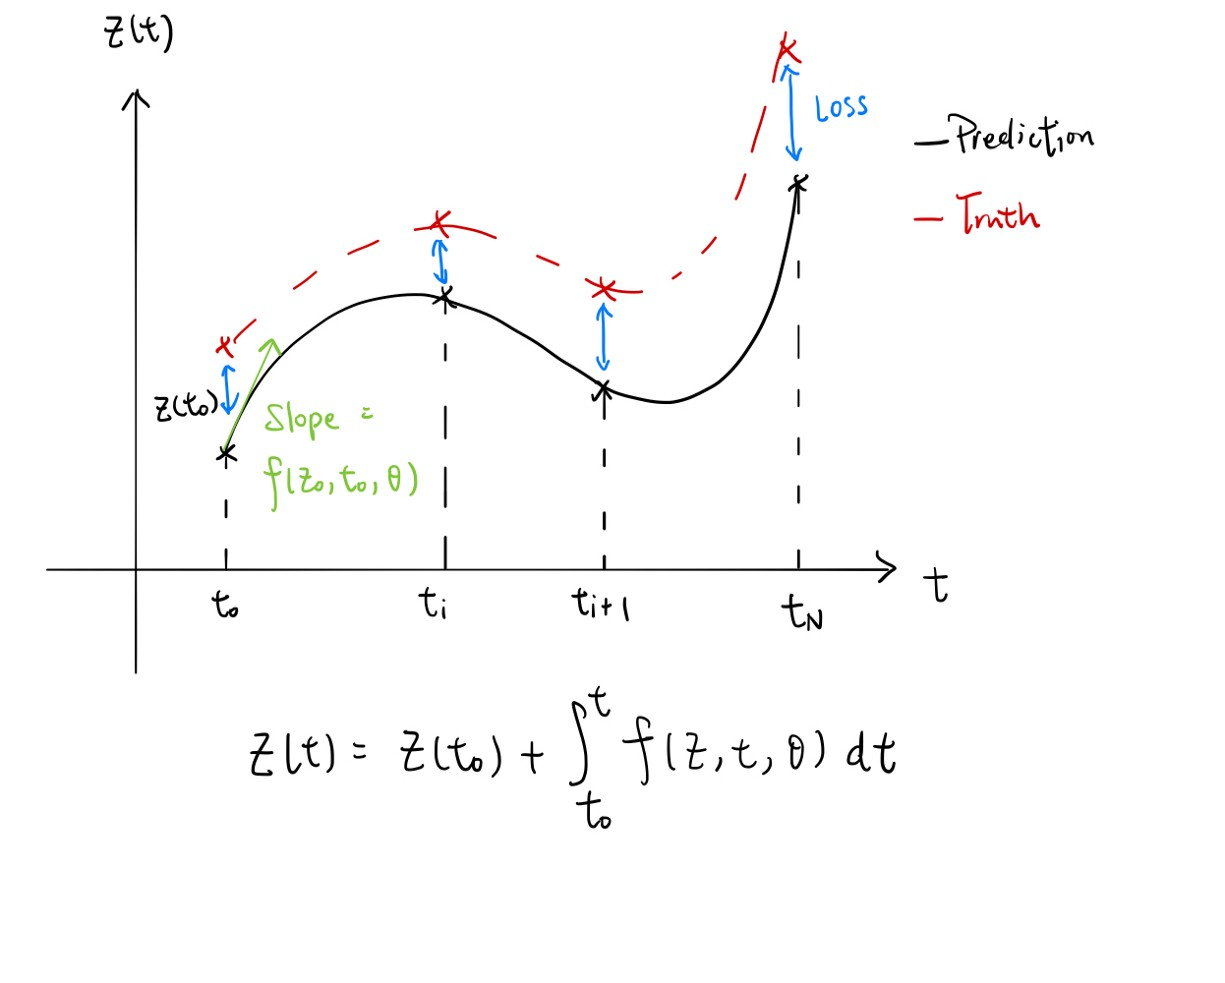

In [4]:
import torch.nn.functional as F
def loss_test():
  loss = F.mse_loss(outputs, labels.detach())

# backward propagation

We can certainly do it on the numerical integrator, but it will introduce high memory cost and numerical error. On the other hand, we can assume that we are doing it on the “Correct path” with infinitesimal step, and compute the gradient irrespective of the integration we use.

But how do we do backpropagation on a continuous path? The loss w.r.t. to parameters will also be continuous, and how do we compute it?


The original authors use the adjoint sensitive method which solves the problem and provides proofs in the appendix


## Continuous Backward Propagation
First, imagine we treat two near points as two separate nodes with share parameters:

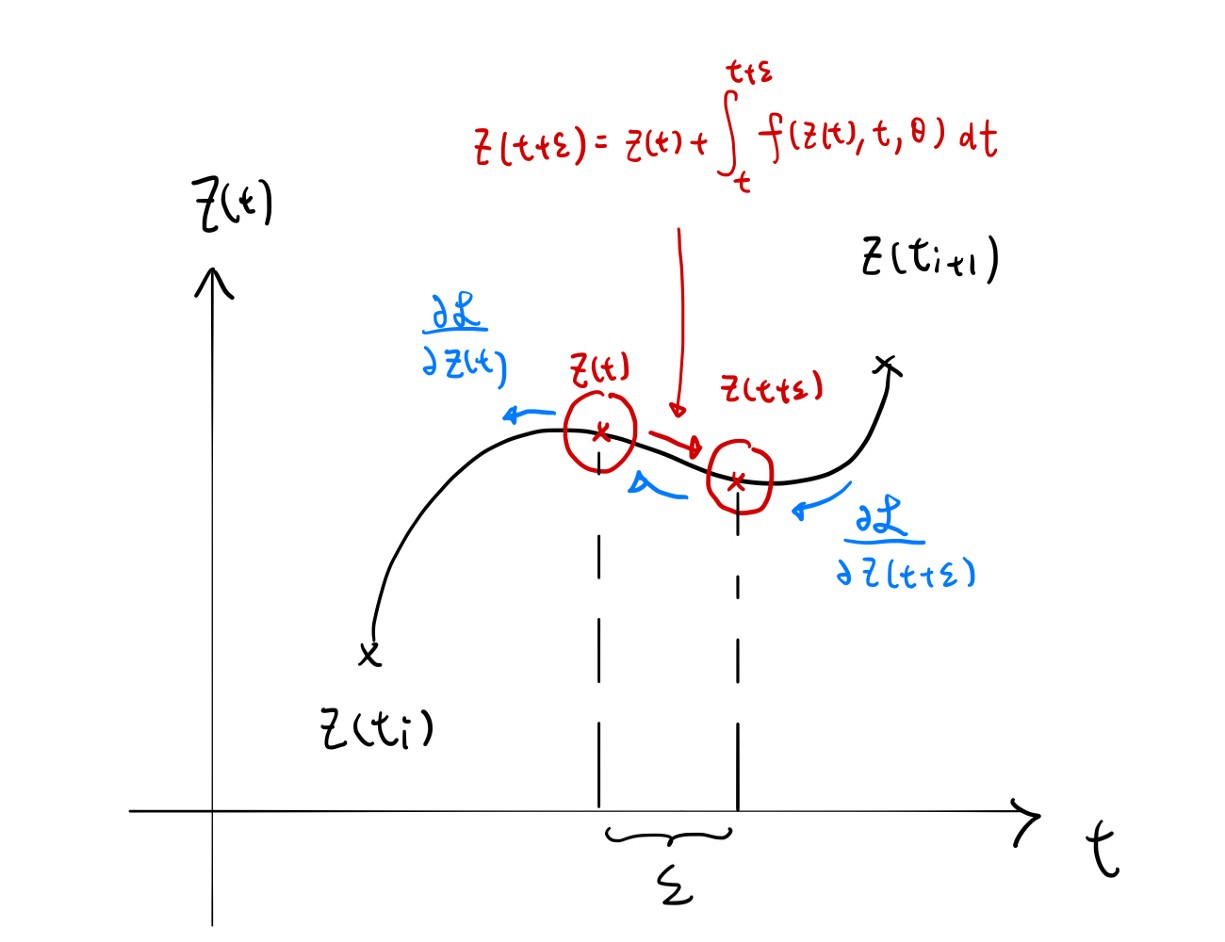




Figure 5: Red arrow shows forward path and blue shows the backward path



Now we can do backward propagation using chain rules:
$$
\frac{\partial L}{\partial \mathbf{z}(\mathbf{t})}=\frac{\partial L}{\partial \mathbf{z}(\mathbf{t}+\varepsilon)} \frac{\partial \mathbf{z}(t+\varepsilon)}{\partial \mathbf{z}(\mathbf{t})}
$$
for ease of notation: we write the partial derivatives as follow
$$
\begin{gathered}
\mathbf{a}(t)=\frac{\mathrm{d} L}{\mathrm{~d} \mathbf{z}(t)} \\
\mathbf{z}(t+\varepsilon)=\mathbf{z}(t)+\int_{t}^{t+\varepsilon} f(\mathbf{z}(t), t, \theta) d t=T_{\varepsilon}(\mathbf{z}(t), t, \theta) \\
a(t)=a(t+\varepsilon) \frac{\partial}{\partial \mathbf{z}(\mathbf{t})} T_{\varepsilon}(\mathbf{z}(t), t, \theta)
\end{gathered}
$$
Notice that a(t) and $z(t)$ have same dimension, and $\mathrm{dT} / \mathrm{dz}$ is Jacobian matrix


Instead of computing the partial derivatives directly, we find the “Change in partial derivatives” by taking limit from discrete case to continuous case.


Notice by taking the limit to 0, we can use the definition of derivative to get **another ODE **to describe how errors are being backpropagated w.r.t. z(t). It is defined as the adjoint differential equation.


## Important implementation detail
The above equation describes the “error dynamic” for between two points on the curve. To accommodate for all pairs, we need to adjust the error by calculating the total change. (notice why there’s 0+ in the limit?) If this is not obvious to the reader (which happens to me), we can compare the computational graph in the discrete case.


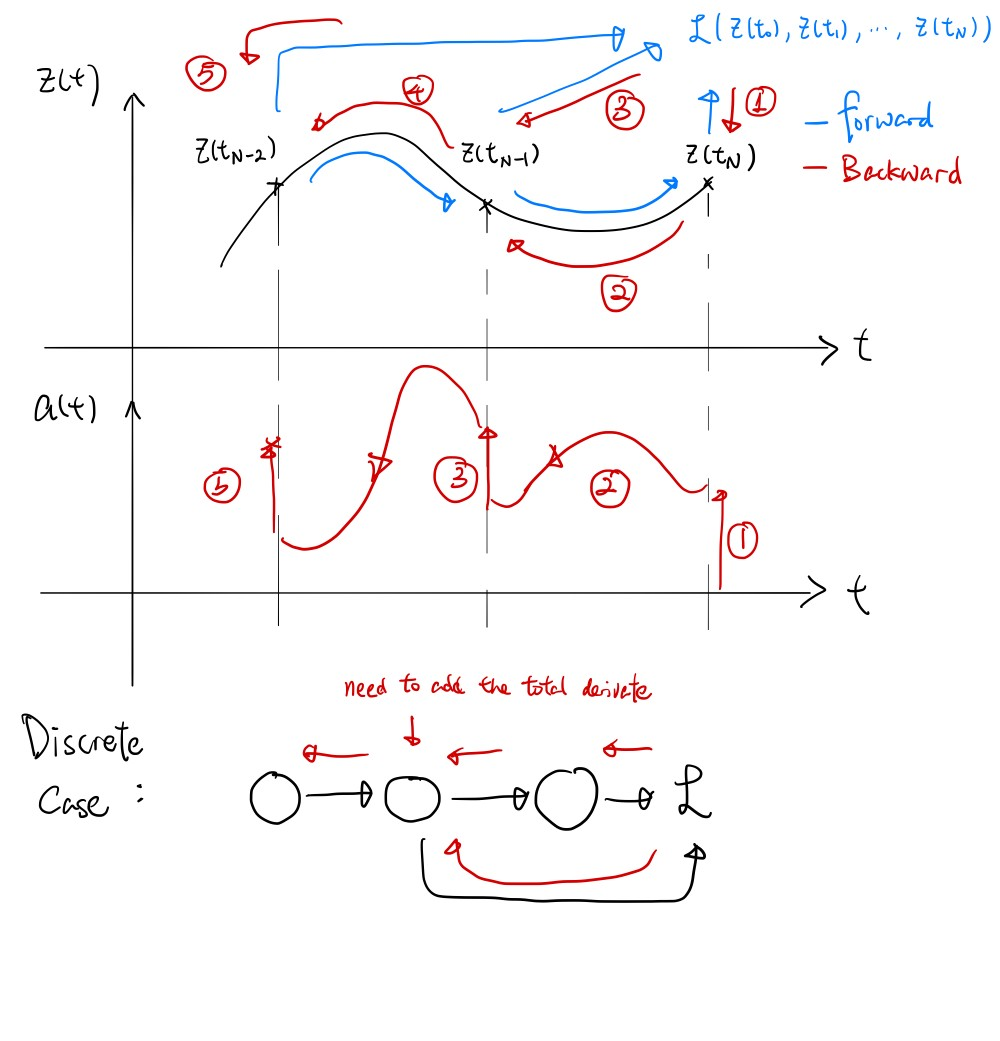

Using this method, we can compute the partial derivative of loss w.r.t every point on the curve.


$\frac{\partial L}{\partial \theta}=\frac{\partial L}{\partial z(t)} \frac{\partial z(t)}{\partial \theta}$

which is hard to compute without the explicit form of z(t).

The original paper proposed a brilliant method to tackle the problem. Instead of treating the parameters as constant to the dynamics / ODE. We treat it as part of the dynamic! We construct an augmented ODE:

$$
\frac{d}{d t}\left[\begin{array}{l}
\mathbf{z} \\
\theta \\
t
\end{array}\right](t)=f_{a u g}([\mathbf{z}, \theta, t]):=\left[\begin{array}{c}
f([\mathbf{z}, \theta, t]) \\
\mathbf{0} \\
1
\end{array}\right], \mathbf{a}_{a u g}:=\left[\begin{array}{c}
\mathbf{a} \\
\mathbf{a}_{\theta} \\
\mathbf{a}_{t}
\end{array}\right], \mathbf{a}_{\theta}(t):=\frac{d L}{d \theta(t)}, \mathbf{a}_{t}(t):=\frac{d L}{d t(t)}
$$
augmented dynamic from the original paper

which treat
$$
\frac{\mathrm{d} \theta}{\mathrm{d} t}=0, \quad \frac{\mathrm{d} t}{\mathrm{~d} t}=1
$$

Now by following the above proof again, replacing

$$
\mathbf{a}(t)=\frac{\mathrm{d} L}{\mathrm{~d} \mathbf{z}(t)}
$$

We have
$$
\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{lllll}
\mathbf{a}_{\mathbf{z}}(t) & a_{\theta}(t) & a_{t}(t)
\end{array}\right]=-\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) & a_{\theta}(t) & a_{t}(t)
\end{array}\right] \frac{\partial f_{\text {aug }}(z(t), t, \theta)}{\partial\left[\begin{array}{lll}
\mathbf{z}(t) & \theta(t) & t(t)
\end{array}\right]}
$$
Parts of the Jacobian are known since we know the "dynamic" of $\theta$ and t.
notice the augmented function for $\theta$ and $t$ are constant hence the corresponding partial derivatives is 0
now we can obtain the adjoint differential equation for all variable of the differential equations.
$$
\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) & a_{\theta}(t) & a_{t}(t)
\end{array}\right]=\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial \mathbf{z}(t)} & \mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial \theta(t)} & \mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial t(t)}
\end{array}\right]
$$
**final "error" dynamic**


Now all we need is the initial points, and we can use any ODE solver to solve

$$
\mathbf{a}_{\mathbf{z}}(t)=\frac{\mathrm{d} L}{\mathrm{~d} \mathbf{z}(t)} \quad \mathbf{a}_{\theta}(t)=\frac{\mathrm{d} L}{\mathrm{~d} \theta(t)} \quad \mathbf{a}_{\mathbf{t}}(t)=\frac{\mathrm{d} L}{\mathrm{~d} t(t)}
$$

## these equation means

example:
$$
\mathbf{a}_{\theta}(t)=\frac{\mathrm{d} L}{\mathrm{~d} \theta(t)}
$$

### Summary

In the continuous case, we only need to find

$$
\mathbf{a}_{\theta}\left(t_{0}\right)=\frac{\mathrm{d} L}{\mathrm{~d} \theta\left(t_{0}\right)}
$$
the first time step of the ODEs.

and we will obtain the total partial derivative of the loss function w.r.t. the parameters.

*initial value *

To find the initial value for the adjoint differential equation, we can use chain rule starting from the loss function.

$$
\begin{aligned}
&\mathbf{a}_{\mathbf{z}}\left(t_{1}\right)=\frac{\mathrm{d} L}{\mathrm{~d} z\left(t_{1}\right)} \\
&a_{\theta}\left(t_{1}\right)=0 \\
&a_{t}\left(t_{1}\right)=\frac{\mathrm{d} L}{\mathrm{~d} \mathbf{z}\left(t_{1}\right)} \frac{\mathrm{d} \mathbf{z}\left(\mathbf{t}_{\mathbf{1}}\right)}{\mathrm{d} t}=\mathbf{a}\left(\mathbf{t}_{\mathbf{1}}\right) f\left(\mathbf{z}\left(\mathbf{t}_{\mathbf{1}}\right), \mathbf{t}_{\mathbf{1}}, \theta\right)
\end{aligned}
$$

## Backward Propagation summary:

- adjoint differential equation

$$
\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) & a_{\theta}(t) & a_{t}(t)
\end{array}\right]=\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial \mathbf{z}(t)} & \mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial \theta(t)} & \mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial t(t)}
\end{array}\right]
$$

- initial value
$$
\begin{aligned}
&\mathbf{a}_{\mathbf{z}}\left(t_{1}\right)=\frac{\mathrm{d} L}{\mathrm{~d} z\left(t_{1}\right)} \\
&a_{\theta}\left(t_{1}\right)=0 \\
&a_{t}\left(t_{1}\right)=\frac{\mathrm{d} L}{\mathrm{~d} \mathbf{z}\left(t_{1}\right)} \frac{\mathrm{d} \mathbf{z}\left(\mathbf{t}_{\mathbf{1}}\right)}{\mathrm{d} t}=\mathbf{a}\left(\mathbf{t}_{\mathbf{1}}\right) f\left(\mathbf{z}\left(\mathbf{t}_{\mathbf{1}}\right), \mathbf{t}_{\mathbf{1}}, \theta\right)
\end{aligned}
$$
- **solve the IVP**

$$
\begin{aligned}
&\mathbf{a}_{\mathbf{z}}\left(t_{0}\right)=\mathbf{a}_{\mathbf{z}}\left(t_{1}\right)+\int_{t_{1}}^{t_{0}} \frac{\left.\mathrm{d} \mathbf{a}_{\mathbf{z}}(t)\right)}{\mathrm{d} t} d t \\
&\mathbf{a}_{\theta}\left(t_{0}\right)=\int_{t_{1}}^{t_{0}} \frac{\left.\mathrm{d} \mathbf{a}_{\theta}(t)\right)}{\mathrm{d} t} d t \\
&\mathbf{a}_{\mathbf{t}}\left(t_{0}\right)=\mathbf{a}_{\mathbf{t}}\left(t_{1}\right)+\int_{t_{1}}^{t_{0}} \frac{\left.\mathrm{d} \mathbf{a}_{\mathbf{t}}(t)\right)}{\mathrm{d} t} d t
\end{aligned}
$$

By solving the adjoint differential equation using any ODE solver, we can perform continuous backward propagation.

excellent!

# Important methods in PyTorch
I am not going into every detail in the code. Interested audience can find it [here](https://github.com/feicccccccc/Neural-ODE-Ex). There are a few important parts that I will cover here which relate to the theory described above.

## 1. Compute the adjoint differential equation at time t

Since the adjoint differential equation requires partial derivative to the ODE function, the easiest way is to use autograd to find the derivatives.

$$
\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) & a_{\theta}(t) & a_{t}(t)
\end{array}\right]=\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial \mathbf{z}(t)} & \mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial \theta(t)} & \mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial t(t)}
\end{array}\right]
$$

final “error” dynamic

remember?

In [5]:
import torch
import torch.nn as nn


class ODEfunc(nn.Module):
    """
    Base Class to represent the Neural Network for the ODE
    i.e. dz/dt = f(z, t; θ)
    To use this Class, subclass it and add User specific Neural Network architecture
    Important function:
    - forward_with_grad
    We need the following things to compute the adjoint state dynamics (da/dt)
    f:      Neural Network output
    dfdz:   Partial derivative of f w.r.t. z at specific time t
    dfdp:   Partial derivative of f w.r.t. parameters at specific time t
    dfdt:   Partial derivative of f w.r.t. t at specific time t
    - flatten_parameters
    Get all the parameter of the Neural Network and flatten it
    """

    def forward_with_grad(self, z, t, grad_outputs):
        """
        Compute the Partial derivative of the Neural Network
        :param z: z value at time t
        :param t: time t
        :param grad_outputs: vector of augmented a [a_z, a_p, a_t]
        :return: Partial derivative (Jacobian) of f = dzdt at direction a
        (f, adfdz, adfdp, adfdt)
        """
        batch_size = z.shape[0]

        # feed forward of f(z,t), by using autograd we can compute the jacobian
        out = self.forward(z, t)
        # direction for autograd
        a = grad_outputs

        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,)
            , (z, t) + tuple(self.parameters())
            , grad_outputs=(a)
            , allow_unused=True
            , retain_graph=True
        )

        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        """
        flatten all parameters inside the Neural Network, so it is easier to compute the gradient with augmented dynamic
        :return: flatten parameters
        """
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [6]:
! git clone https://github.com/feicccccccc/Neural-ODE-Ex.git

Cloning into 'Neural-ODE-Ex'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 31 (delta 12), reused 19 (delta 5), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [7]:
%cd Neural-ODE-Ex/

/content/Neural-ODE-Ex


Now notice in `torch.autograd.grad()` we have an option to choose the output direction. If we use the adjoint state as direction, PyTorch automatically gives us the augmented dynamic we want.

## Custom PyTorch function to perform forward and backward propagation

In [8]:
import torch
from NeuralODE import ODEfunc
from ODE_solver import ode_solve
import numpy as np


class ODEAdjoint(torch.autograd.Function):
    """
    Custom made autograd function to perform continuous backpropgation
    define by forward and backward static method
    """
    #In forward pass, it simply means solving the Neural ODE function IVP.
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        """
        forward propagation, solve the given ODE
        dzdt = f(z,t)
        with initial z(t0) = z0
        and find z(t) for t predefined time stamp
        :param ctx: for saving useful information during forward cal
        :param z0: initial z (bs, z_dim)
        :param t: all time stamp (time step, 1, 1)
        :param flat_parameters: flatten parameter
        :param func: the Neural Network represent the ODE function
        :return: (time_len, bs, z_shape)
        """
        assert isinstance(func, ODEfunc)
        bs, *z_shape = z0.size()    # (batch size, z_shape), *for unrolling the tuple
        time_len = t.size(0)


        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: (time_len, batch_size, *z_shape)
        Notice the first one is zero if we choose the starting point
        to be the same as the one from true label to start with
        """

        # for enabling Pycharm breakpoint in backward function
        # disable to run in normal mode
        import pydevd
        pydevd.settrace(suspend=False, trace_only_current_thread=True)

        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()

        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is t
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            :param aug_z_i: (bs, n_dim*2 + n_params + 1)
            :param t_i: (bs, 1)
            :return:
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience

        with torch.no_grad():
            # Create placeholders for output gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            # actually I have no idea why we need dLdt and dLdz, but anyway
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                # batch matrix product
                a_t = torch.transpose(dLdz_i.unsqueeze(-1), 1, 2)
                dLdt_i = -torch.bmm(a_t, f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                # Think in terms of chain rule with fix paramter on different node
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] + dLdt_i

                # Pack augmented variable
                # z(t_N), adj_z, 0, adj_t
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dLdz_0 = dLdz[0]
            dLdt_0 = -torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] + dLdt_0
        # forward: (z0, t, parameters, func)
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

from highlight

1. Remember to adjust the gradient at each data point. The gradient contributes from both the path and the loss refer to the above figures.
2. The augmented dynamic, and adjoint state computation follows the algorithm from appendix C.

# Put it all in torch

thanks https://github.com/feicccccccc/Neural-ODE-Ex

## ODE solver

We can solve the following ODE
$$
\frac{\mathrm{d} \mathbf{z}}{\mathrm{d} t}=f(\mathbf{z}, t, \theta)
$$
notice here $\mathbf{z}$ is a vector, $\theta$ is the parameters of the function
by integrating along the path

In [10]:
import math


def ode_solve(z0, t0, t1, f):
    """
    Simple Euler ODE initial Value solver
    :param z0: initial time
    :param t0: initial time stamp
    :param t1: target time stamp
    :param f: ODE function
    :return: z1
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0) / h_max).max().item())

    h = (t1 - t0) / n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

## ODEfunc (along the path)

Base Class to represent the Neural Network for the ODE

by integrating along the path
$$
\mathbf{z}(t)=\boldsymbol{z}\left(t_{0}\right)+\int_{t_{o}}^{t} f(\mathbf{z}, t, \theta) d t
$$
start from $t_0$ and follow the slope to generate $\mathrm{z}$ from later time step

In [9]:
import torch
import torch.nn as nn


class ODEfunc(nn.Module):
    """
    Base Class to represent the Neural Network for the ODE
    i.e. dz/dt = f(z, t; θ)
    To use this Class, subclass it and add User specific Neural Network architecture
    Important function:
    - forward_with_grad
    We need the following things to compute the adjoint state dynamics (da/dt)
    f:      Neural Network output
    dfdz:   Partial derivative of f w.r.t. z at specific time t
    dfdp:   Partial derivative of f w.r.t. parameters at specific time t
    dfdt:   Partial derivative of f w.r.t. t at specific time t
    - flatten_parameters
    Get all the parameter of the Neural Network and flatten it
    """

    def forward_with_grad(self, z, t, grad_outputs):
        """
        Compute the Partial derivative of the Neural Network
        :param z: z value at time t
        :param t: time t
        :param grad_outputs: vector of augmented a [a_z, a_p, a_t]
        :return: Partial derivative (Jacobian) of f = dzdt at direction a
        (f, adfdz, adfdp, adfdt)
        """
        batch_size = z.shape[0]

        # feed forward of f(z,t), by using autograd we can compute the jacobian
        out = self.forward(z, t)
        # direction for autograd
        a = grad_outputs

        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,)
            , (z, t) + tuple(self.parameters())
            , grad_outputs=(a)
            , allow_unused=True
            , retain_graph=True
        )

        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        """
        flatten all parameters inside the Neural Network, so it is easier to compute the gradient with augmented dynamic
        :return: flatten parameters
        """
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

## Continuous backpropgation


- adjoint differential equation

$$
\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) & a_{\theta}(t) & a_{t}(t)
\end{array}\right]=\left[\begin{array}{lll}
\mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial \mathbf{z}(t)} & \mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial \theta(t)} & \mathbf{a}_{\mathbf{z}}(t) \frac{\partial f}{\partial t(t)}
\end{array}\right]
$$

- initial value
$$
\begin{aligned}
&\mathbf{a}_{\mathbf{z}}\left(t_{1}\right)=\frac{\mathrm{d} L}{\mathrm{~d} z\left(t_{1}\right)} \\
&a_{\theta}\left(t_{1}\right)=0 \\
&a_{t}\left(t_{1}\right)=\frac{\mathrm{d} L}{\mathrm{~d} \mathbf{z}\left(t_{1}\right)} \frac{\mathrm{d} \mathbf{z}\left(\mathbf{t}_{\mathbf{1}}\right)}{\mathrm{d} t}=\mathbf{a}\left(\mathbf{t}_{\mathbf{1}}\right) f\left(\mathbf{z}\left(\mathbf{t}_{\mathbf{1}}\right), \mathbf{t}_{\mathbf{1}}, \theta\right)
\end{aligned}
$$
- **solve the IVP**

$$
\begin{aligned}
&\mathbf{a}_{\mathbf{z}}\left(t_{0}\right)=\mathbf{a}_{\mathbf{z}}\left(t_{1}\right)+\int_{t_{1}}^{t_{0}} \frac{\left.\mathrm{d} \mathbf{a}_{\mathbf{z}}(t)\right)}{\mathrm{d} t} d t \\
&\mathbf{a}_{\theta}\left(t_{0}\right)=\int_{t_{1}}^{t_{0}} \frac{\left.\mathrm{d} \mathbf{a}_{\theta}(t)\right)}{\mathrm{d} t} d t \\
&\mathbf{a}_{\mathbf{t}}\left(t_{0}\right)=\mathbf{a}_{\mathbf{t}}\left(t_{1}\right)+\int_{t_{1}}^{t_{0}} \frac{\left.\mathrm{d} \mathbf{a}_{\mathbf{t}}(t)\right)}{\mathrm{d} t} d t
\end{aligned}
$$

By solving the adjoint differential equation using any ODE solver, we can perform continuous backward propagation.

excellent!

In [ ]:
import torch
from NeuralODE import ODEfunc
from ODE_solver import ode_solve
import numpy as np


class ODEAdjoint(torch.autograd.Function):
    """
    Custom made autograd function to perform continuous backpropgation
    define by forward and backward static method
    """
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        """
        forward propagation, solve the given ODE
        dzdt = f(z,t)
        with initial z(t0) = z0
        and find z(t) for t predefined time stamp
        :param ctx: for saving useful information during forward cal
        :param z0: initial z (bs, z_dim)
        :param t: all time stamp (time step, 1, 1)
        :param flat_parameters: flatten parameter
        :param func: the Neural Network represent the ODE function
        :return: (time_len, bs, z_shape)
        """
        assert isinstance(func, ODEfunc)
        bs, *z_shape = z0.size()    # (batch size, z_shape), *for unrolling the tuple
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: (time_len, batch_size, *z_shape)
        Notice the first one is zero if we choose the starting point
        to be the same as the one from true label to start with
        """

        # for enabling Pycharm breakpoint in backward function
        # disable to run in normal mode
        import pydevd
        pydevd.settrace(suspend=False, trace_only_current_thread=True)

        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()

        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is t
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            :param aug_z_i: (bs, n_dim*2 + n_params + 1)
            :param t_i: (bs, 1)
            :return:
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience

        with torch.no_grad():
            # Create placeholders for output gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            # actually I have no idea why we need dLdt and dLdz, but anyway
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                # batch matrix product
                a_t = torch.transpose(dLdz_i.unsqueeze(-1), 1, 2)
                dLdt_i = -torch.bmm(a_t, f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                # Think in terms of chain rule with fix paramter on different node
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] + dLdt_i

                # Pack augmented variable
                # z(t_N), adj_z, 0, adj_t
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dLdz_0 = dLdz[0]
            dLdt_0 = -torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] + dLdt_0
        # forward: (z0, t, parameters, func)
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

## NeuralODE

In [11]:
import torch
from torch import nn
from torch import Tensor
from ODEfunc import ODEfunc
from Adjoint import ODEAdjoint


class NeuralODE(nn.Module):
    """
    Wrapper Class to represent the whole Neural ODE
    Need the following component:
    func: the Neural network
    """
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEfunc)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        """
        Use ODE solver to solve the ODE problem,
        The continuous backward propagation is implemented in ODEAdjoint Function.
        :param z0: initial value (bs, z_dim)
        :param t: time step (time, 1, 1)
        :param return_whole_sequence: Bool
        :return: the solved z(t)
        """
        t = t.to(z0)    # Match the data type to z0
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

## utils

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns

sns.color_palette("bright")


def to_np(x):
    return x.detach().cpu().numpy()


def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    """
    plotter for the trajectory
    :param obs: true observation
    :param times: all time step
    :param trajs: predicted trajectory
    :param save: bool
    :param figsize:
    :return: None
    """
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None:
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

## Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


step: 0, loss: 0.5797346830368042


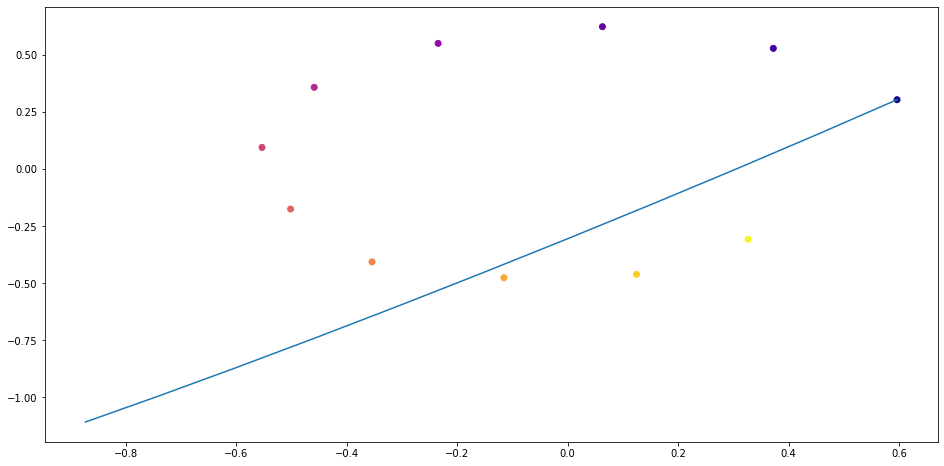

step: 50, loss: 0.2778356373310089


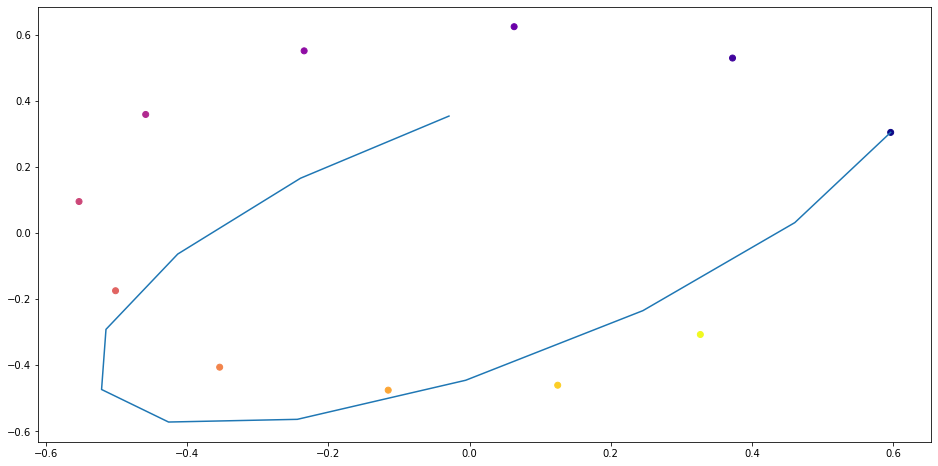

step: 100, loss: 0.18187755346298218


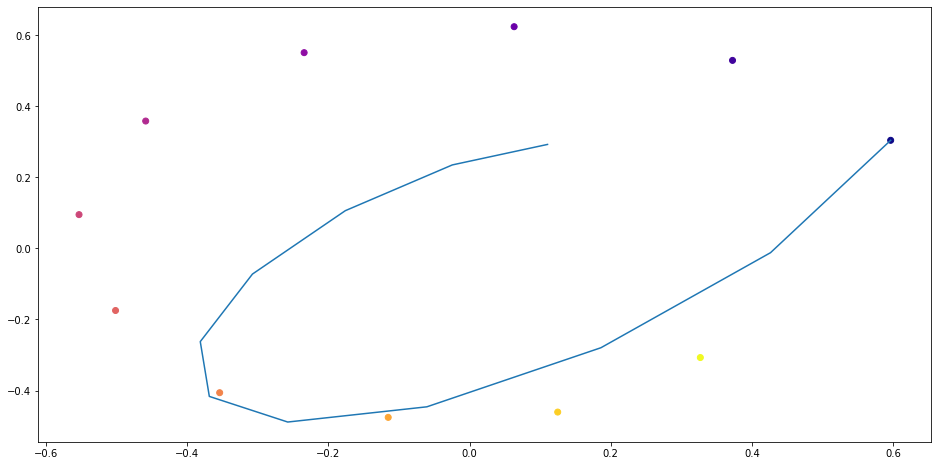

step: 150, loss: 0.29828765988349915


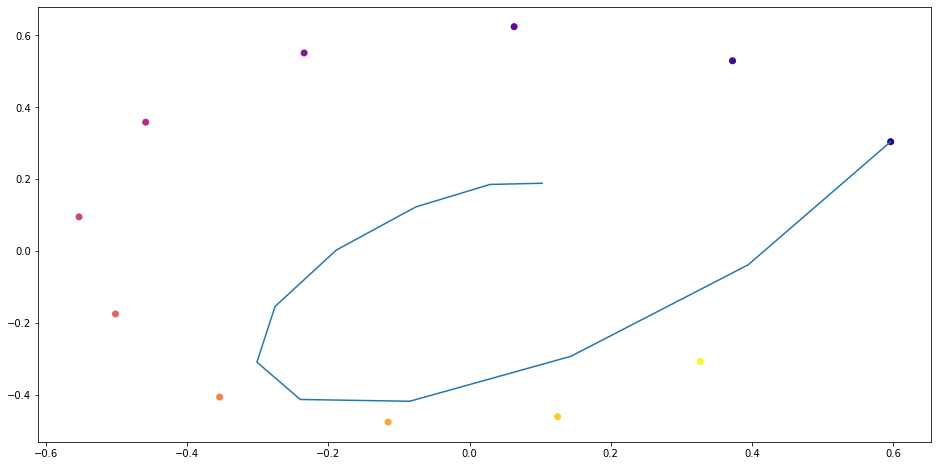

step: 200, loss: 0.1385682374238968


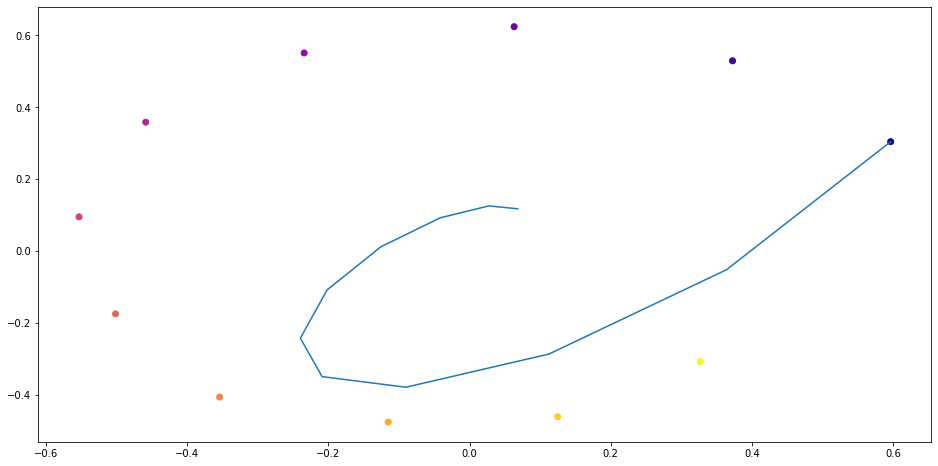

step: 250, loss: 0.19368673861026764


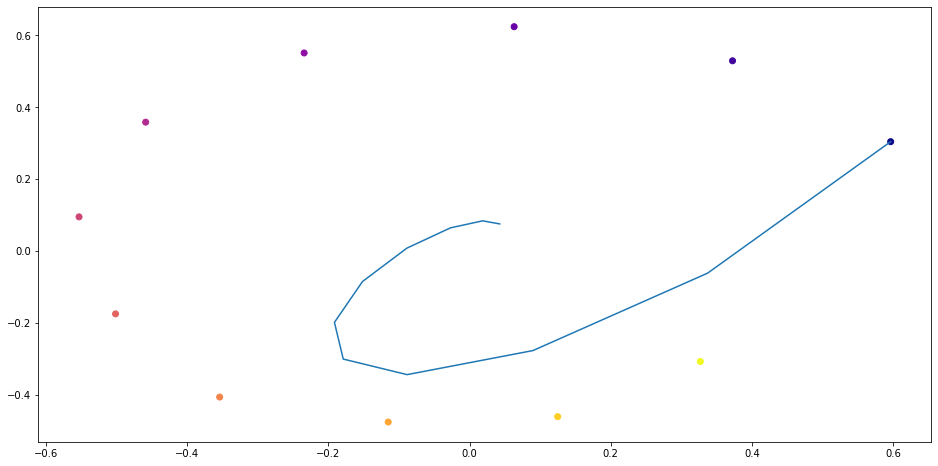

step: 300, loss: 0.18244366347789764


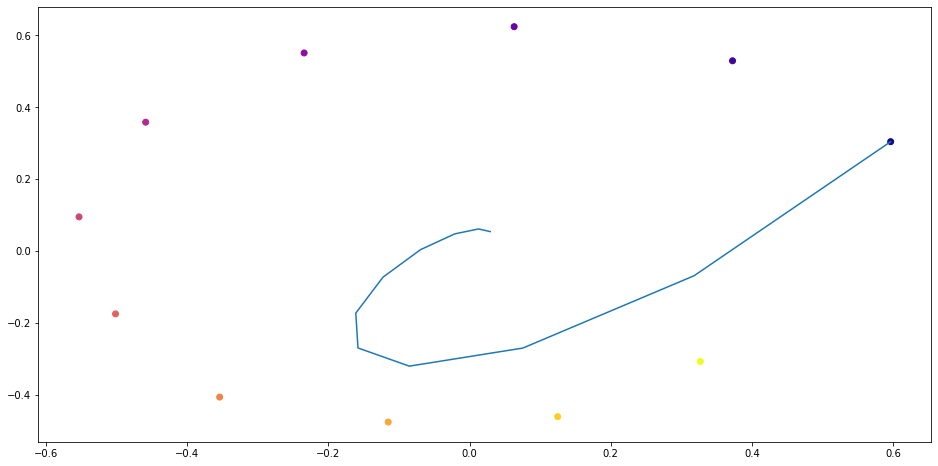

step: 350, loss: 0.1851034313440323


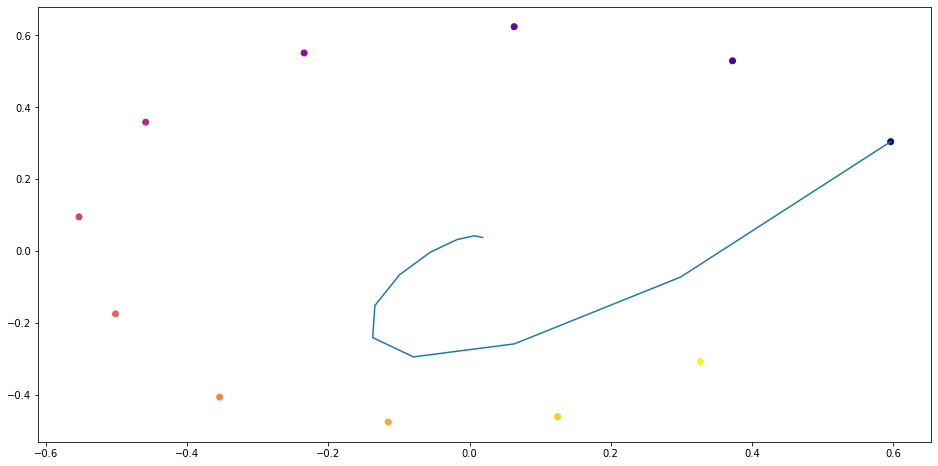

step: 400, loss: 0.18618729710578918


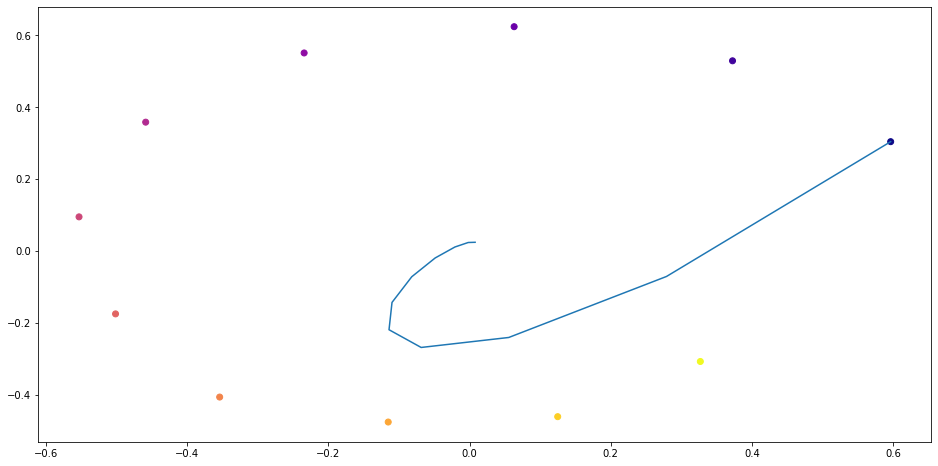

step: 450, loss: 0.11834584921598434


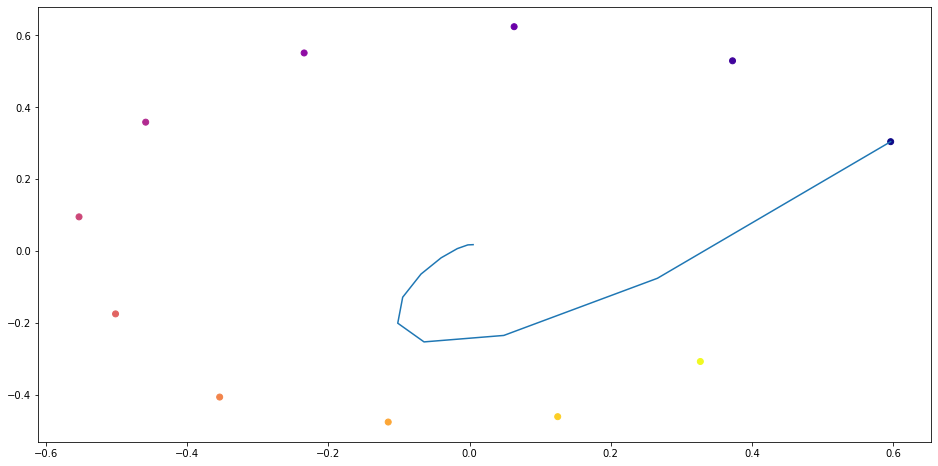

step: 500, loss: 0.16752062737941742


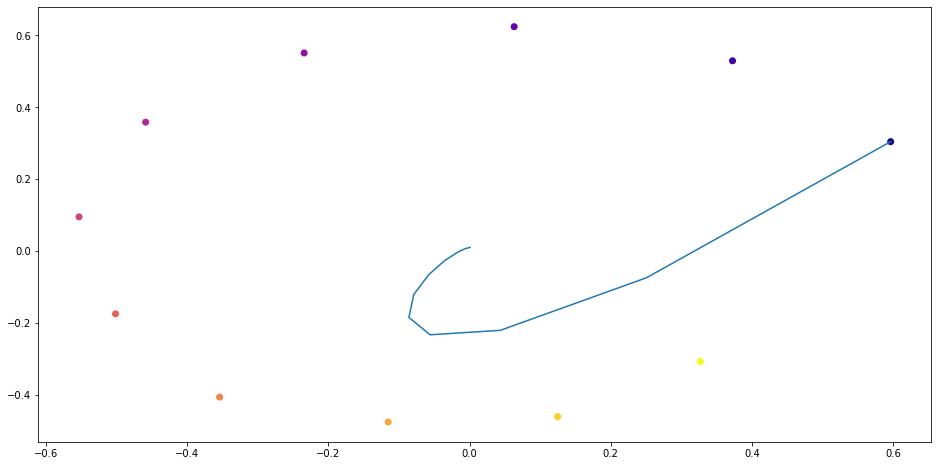

step: 550, loss: 0.14418639242649078


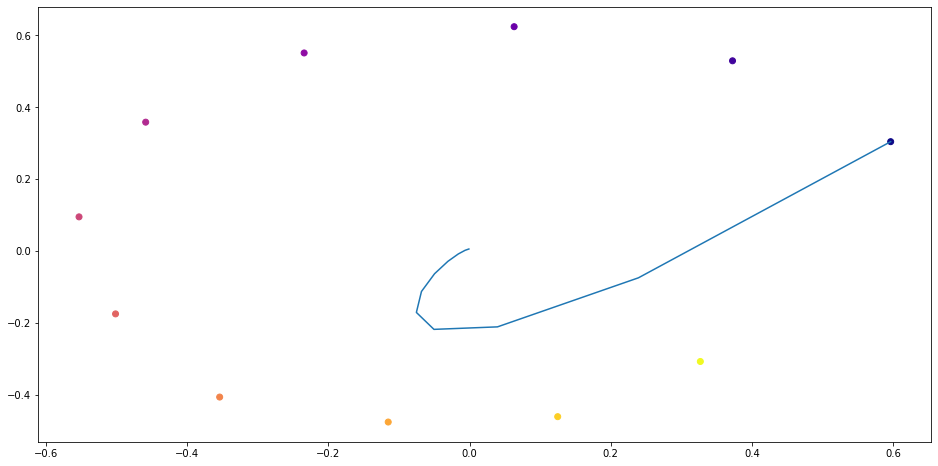

step: 600, loss: 0.04050562530755997


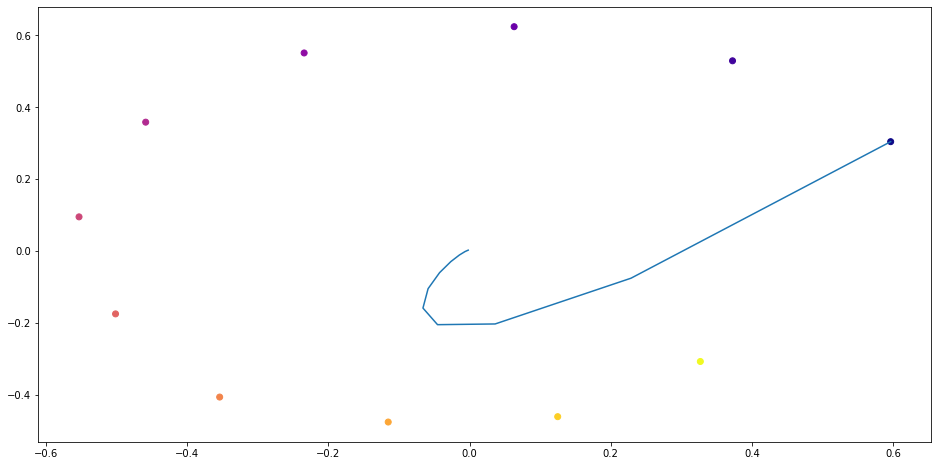

step: 650, loss: 0.12146198749542236


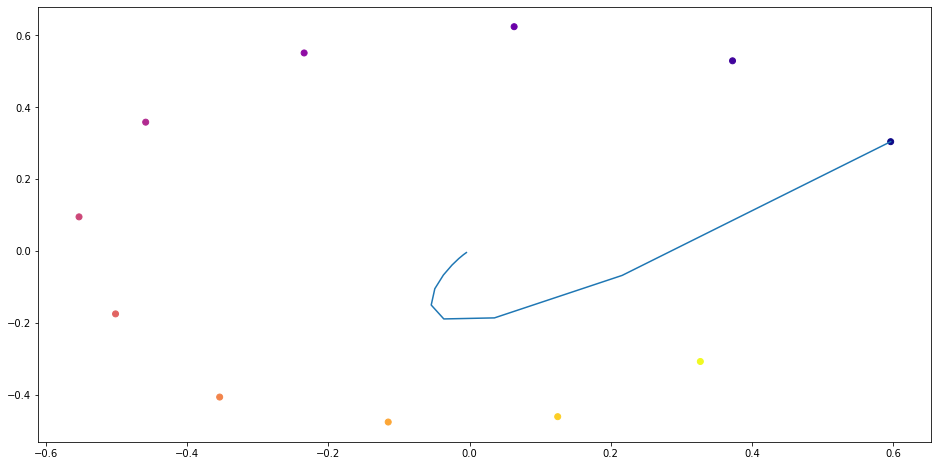

step: 700, loss: 0.15557754039764404


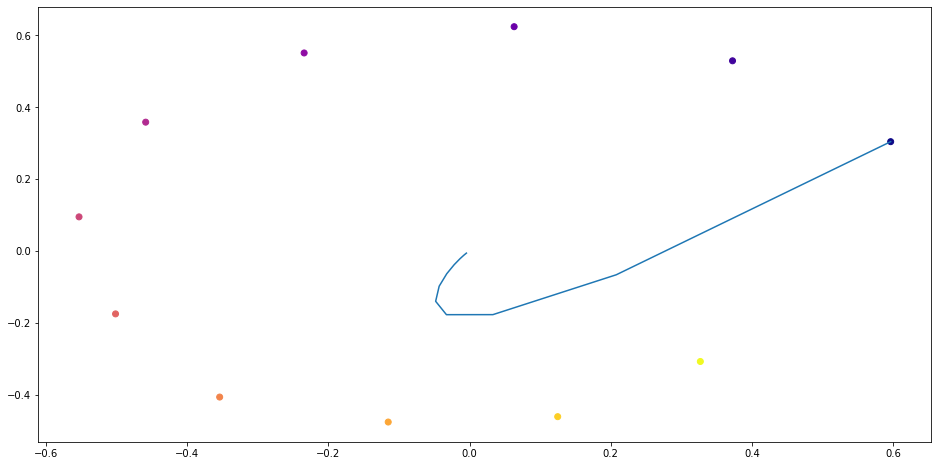

step: 750, loss: 0.12263581901788712


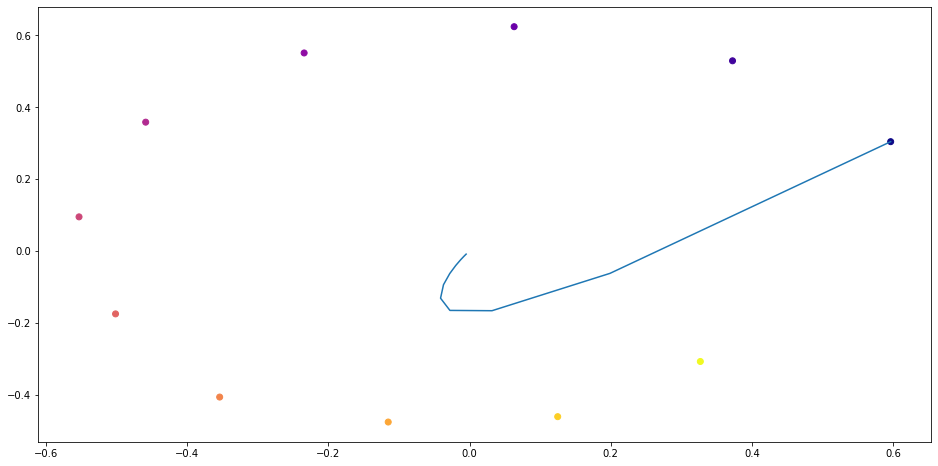

step: 800, loss: 0.07230911403894424


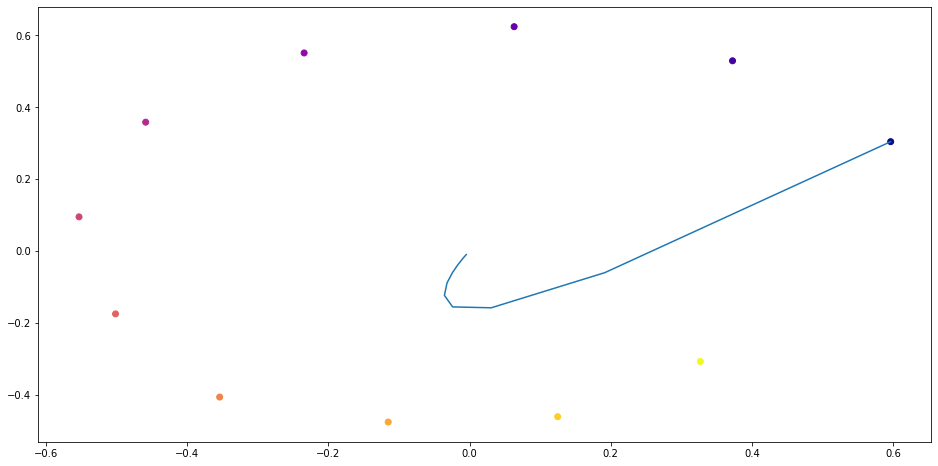

step: 850, loss: 0.1214645579457283


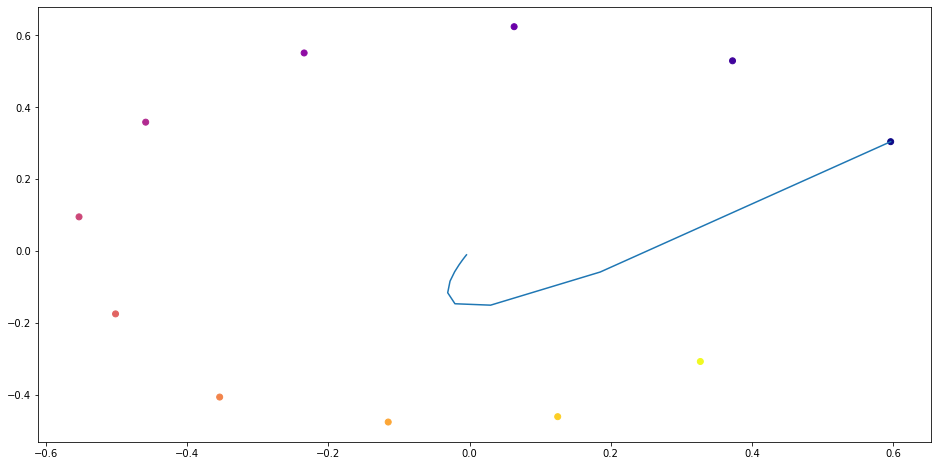

step: 900, loss: 0.11529278755187988


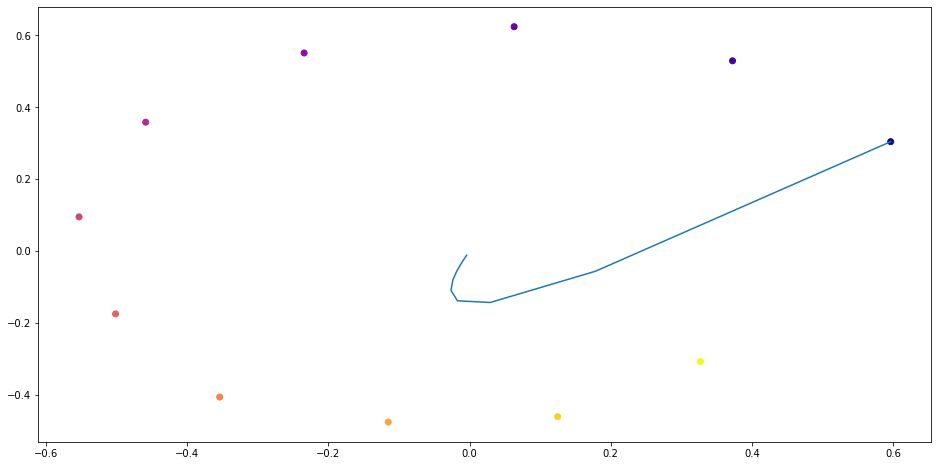

step: 950, loss: 0.14816391468048096


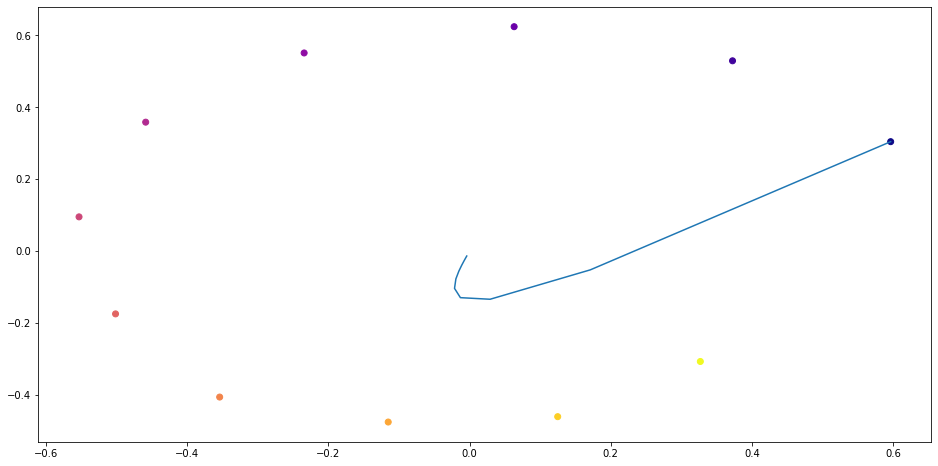

step: 1000, loss: 0.1499103158712387


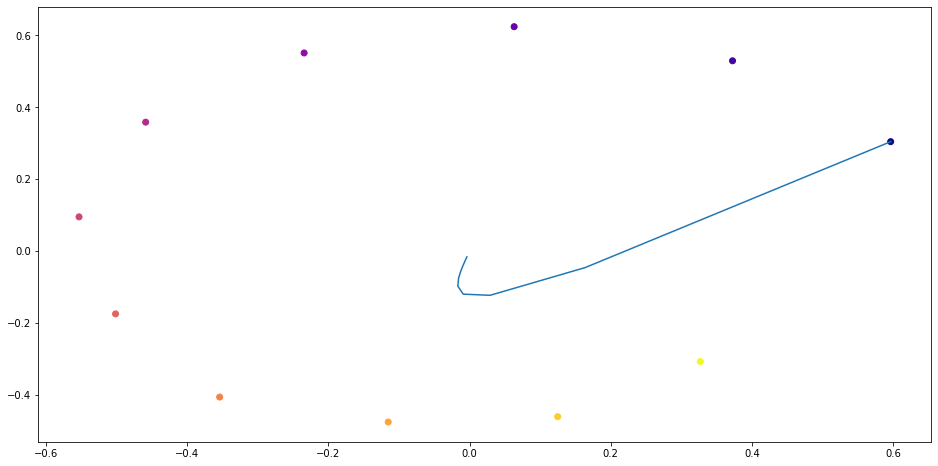

step: 1050, loss: 0.02608720399439335


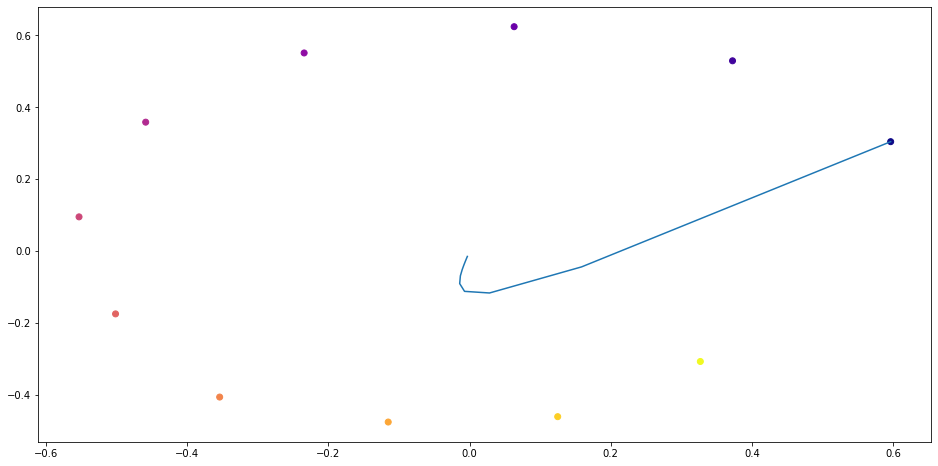

step: 1100, loss: 0.11768537759780884


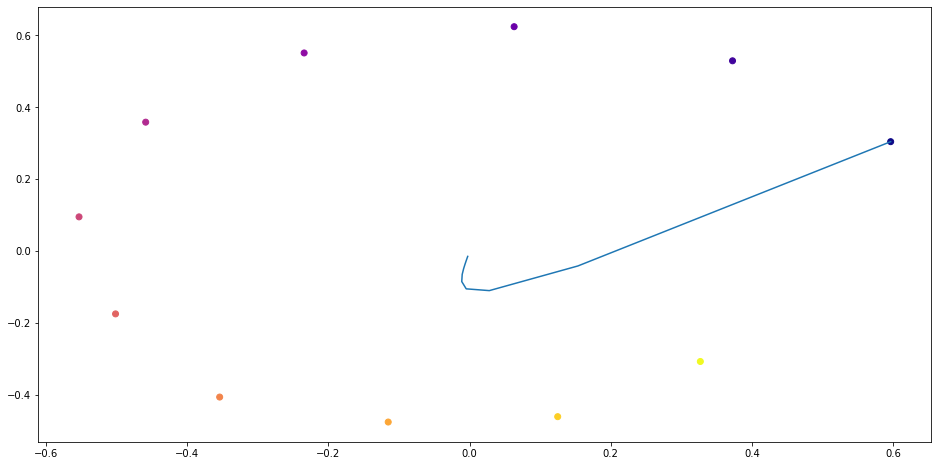

step: 1150, loss: 0.11773093044757843


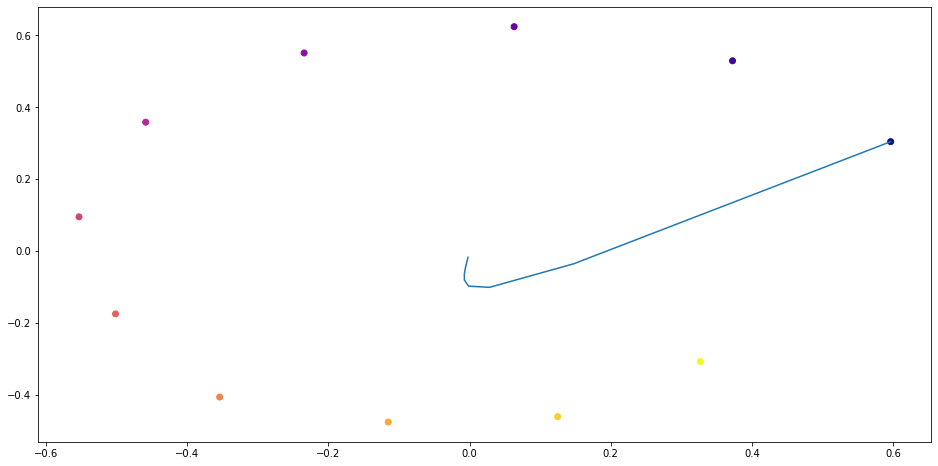

step: 1200, loss: 0.10712549835443497


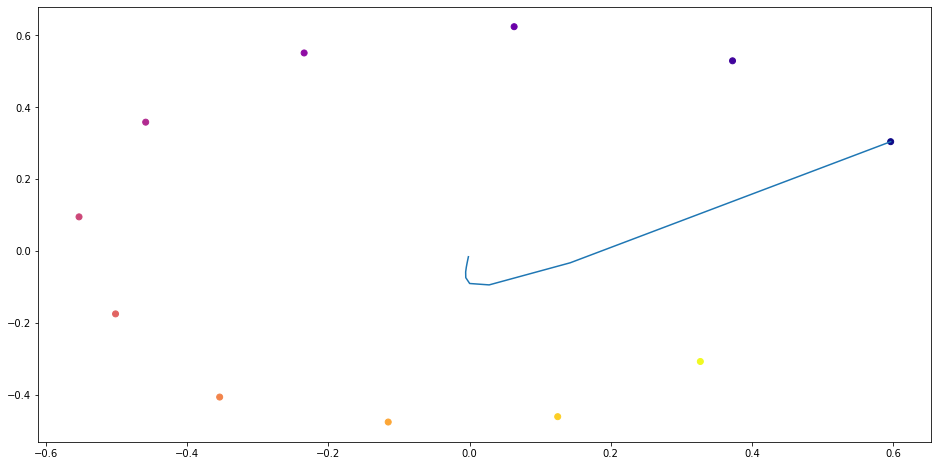

step: 1250, loss: 0.08641911298036575


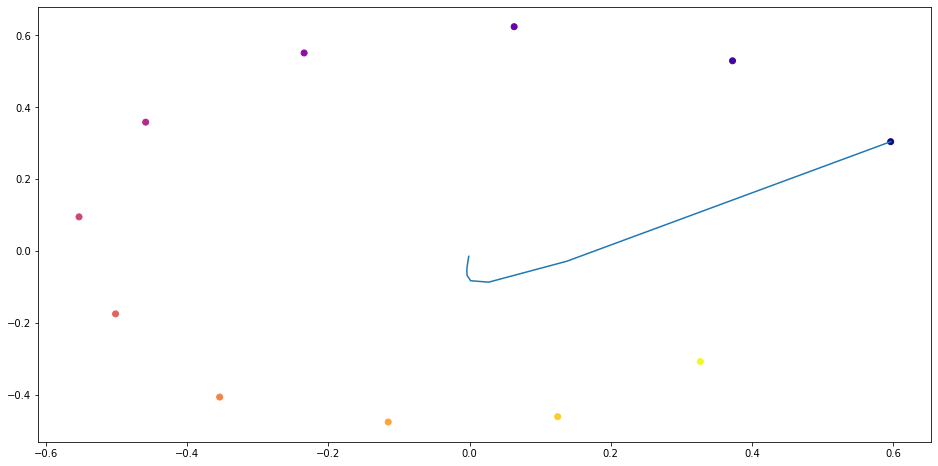

step: 1300, loss: 0.08012590557336807


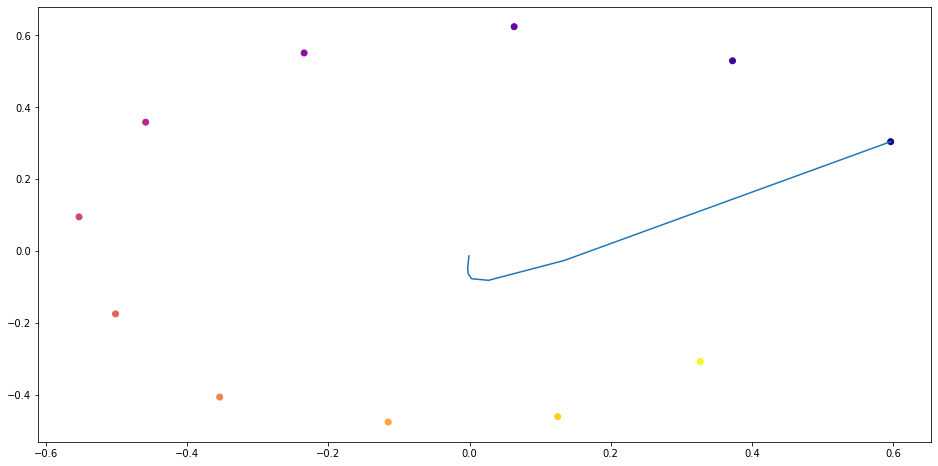

step: 1350, loss: 0.08097358793020248


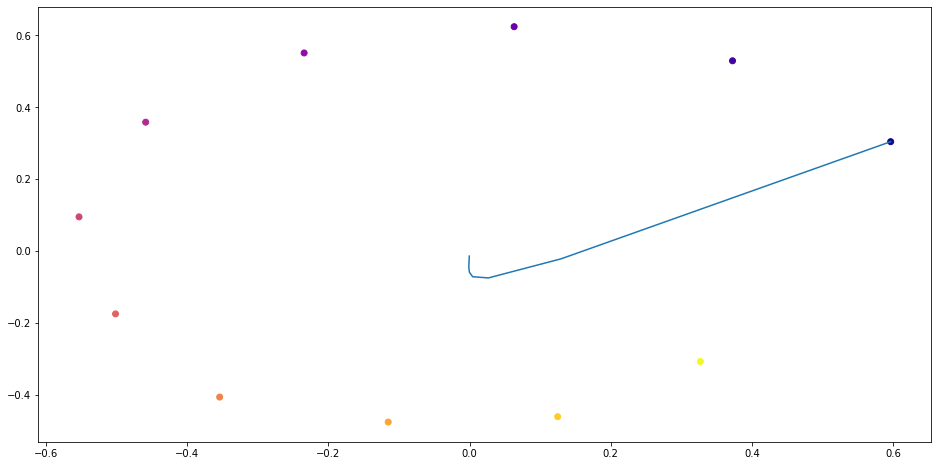

step: 1400, loss: 0.05819294974207878


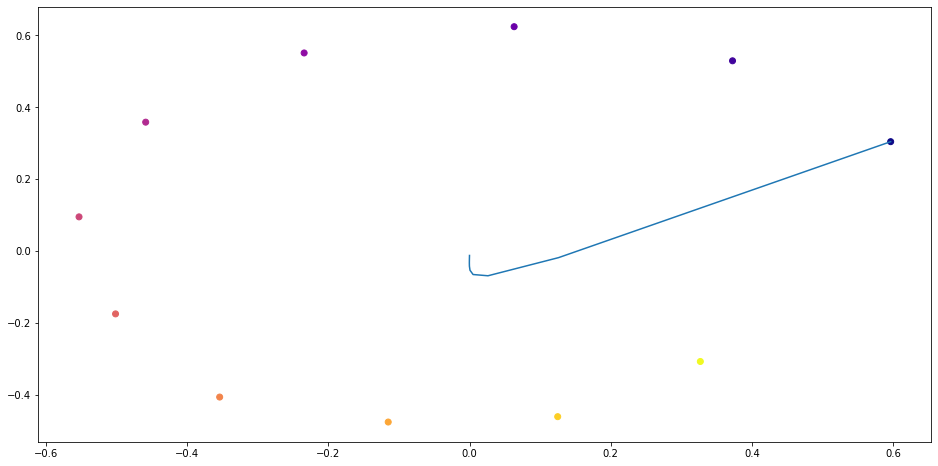

step: 1450, loss: 0.016605660319328308


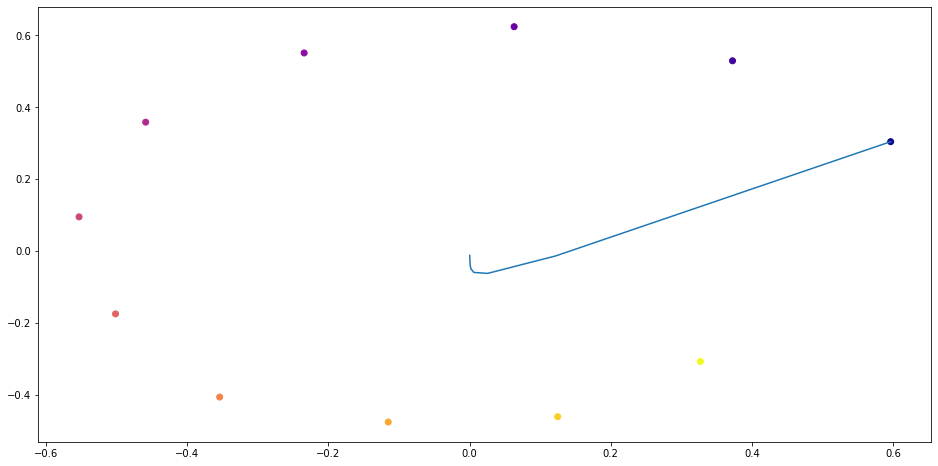

step: 1500, loss: 0.11069449037313461


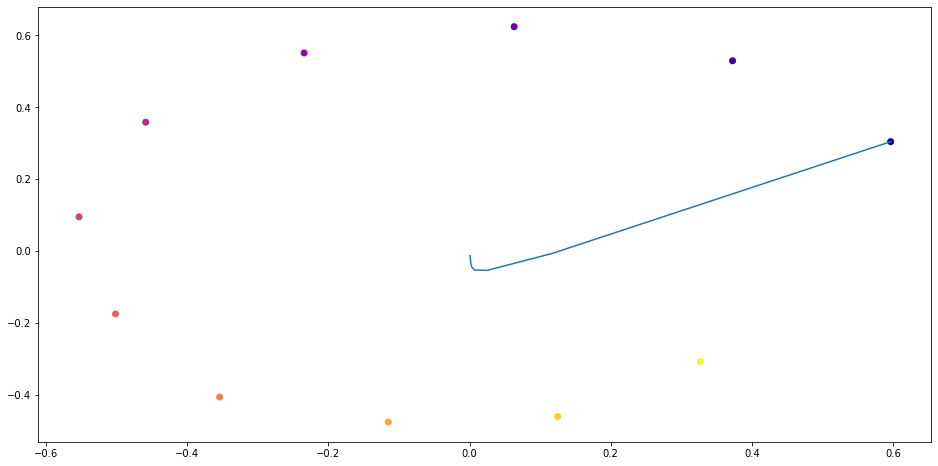

step: 1550, loss: 0.11489710211753845


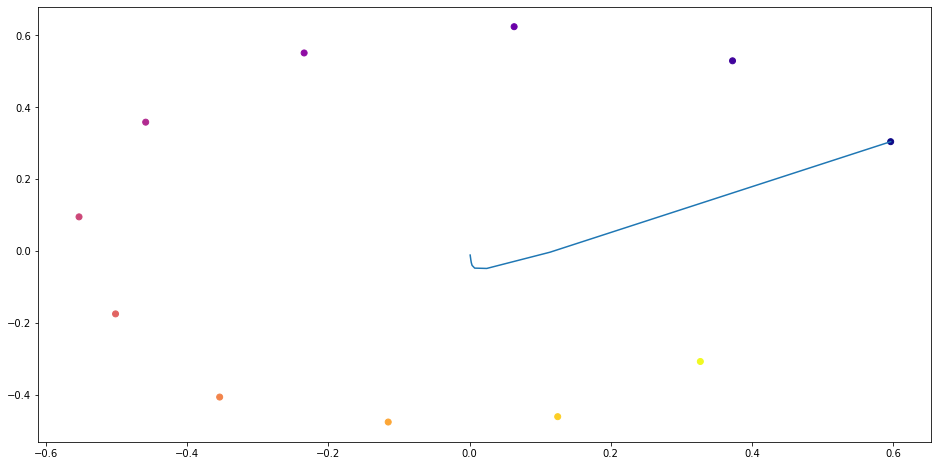

step: 1600, loss: 0.013154607266187668


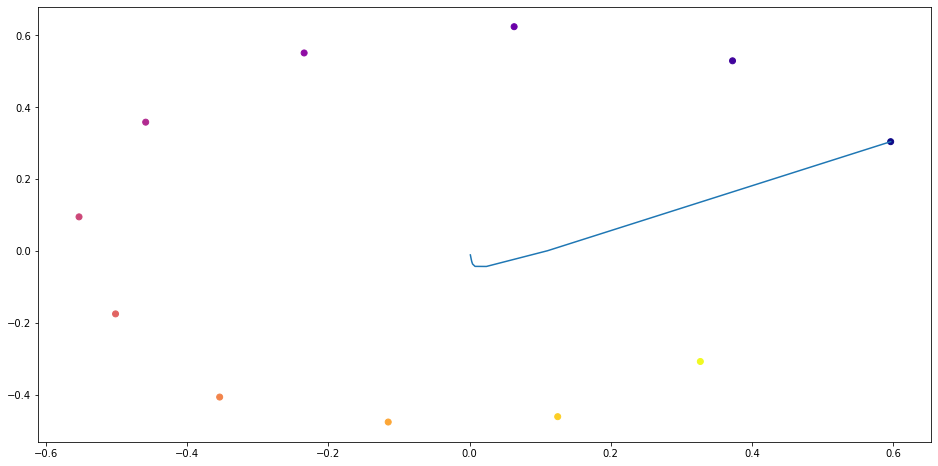

step: 1650, loss: 0.06900250911712646


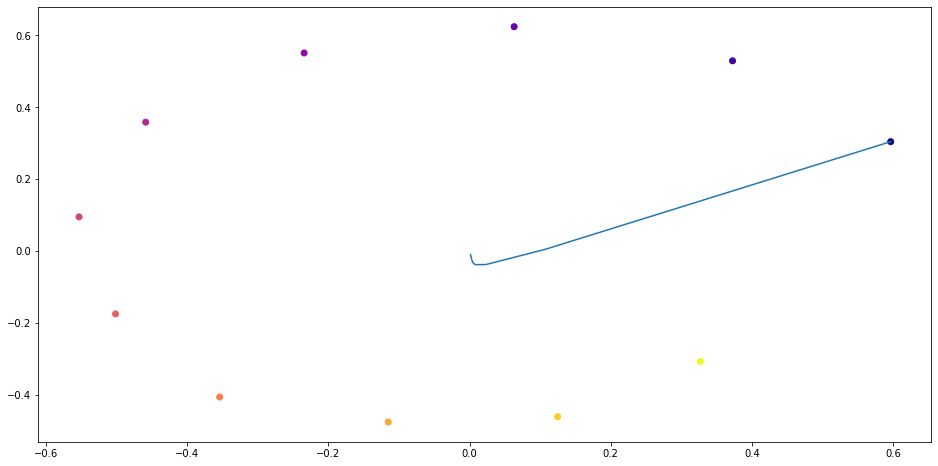

step: 1700, loss: 0.11275970935821533


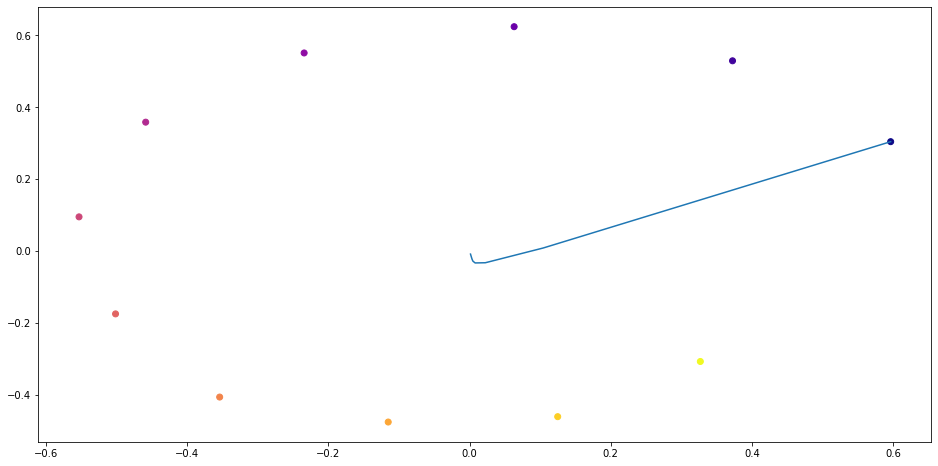

step: 1750, loss: 0.08087322860956192


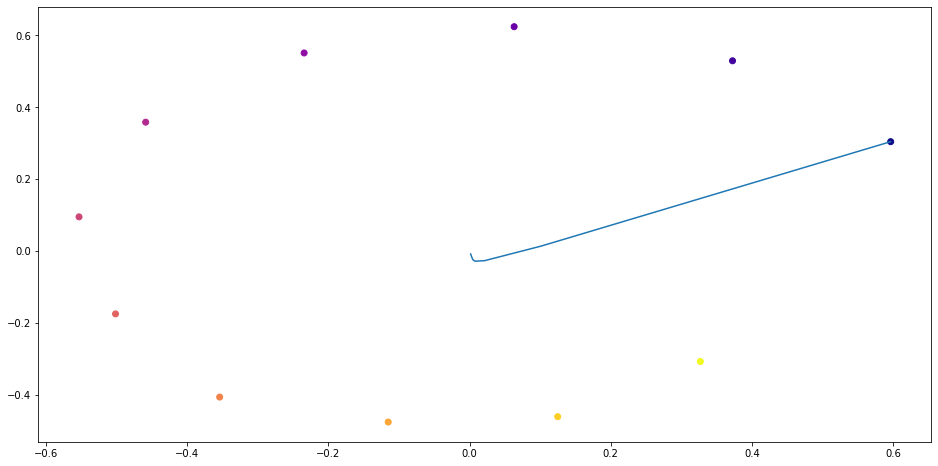

step: 1800, loss: 0.06472288817167282


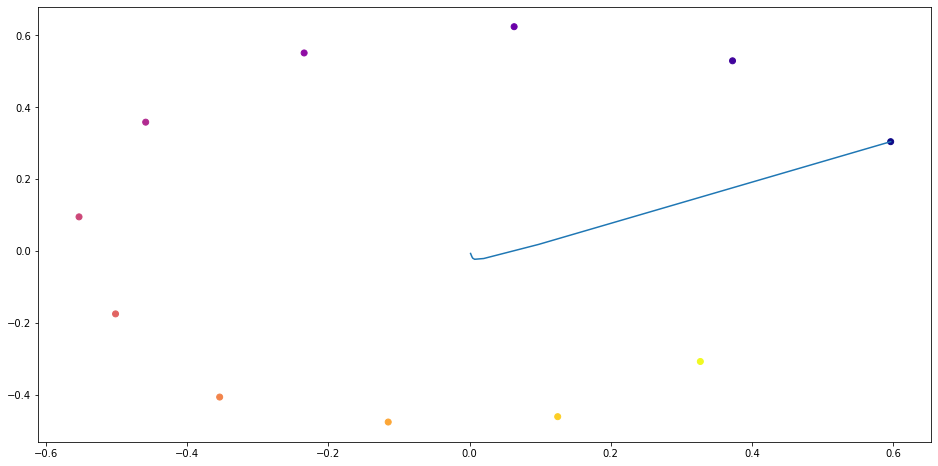

step: 1850, loss: 0.00873510167002678


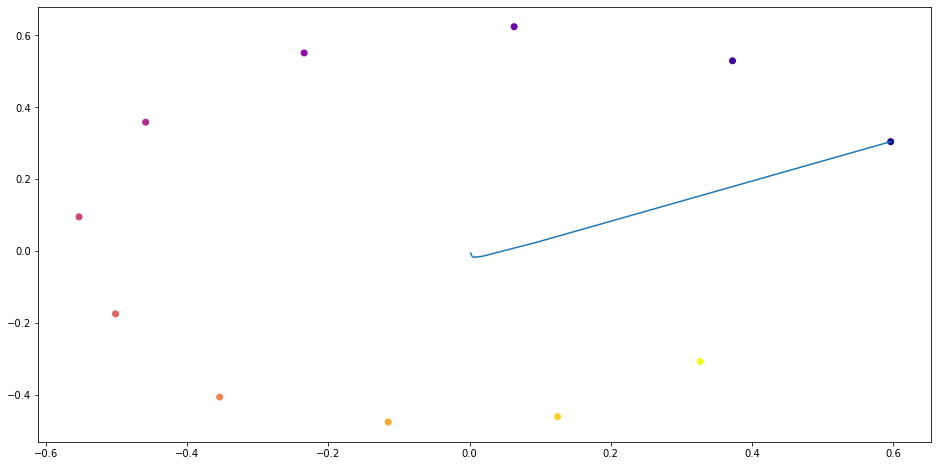

step: 1900, loss: 0.07680929452180862


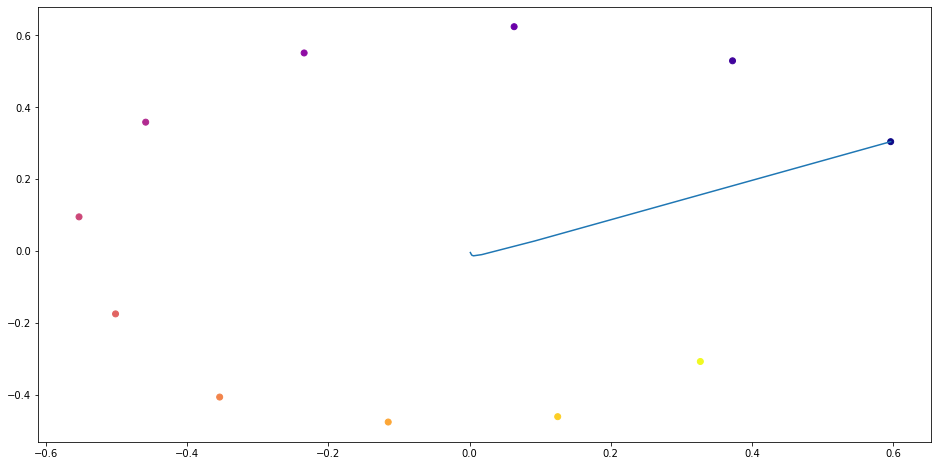

step: 1950, loss: 0.1340014636516571


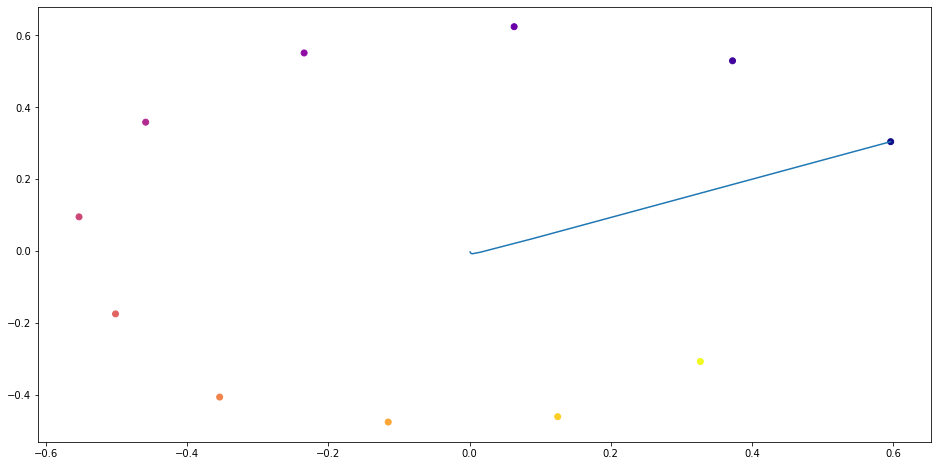

step: 2000, loss: 0.09977422654628754


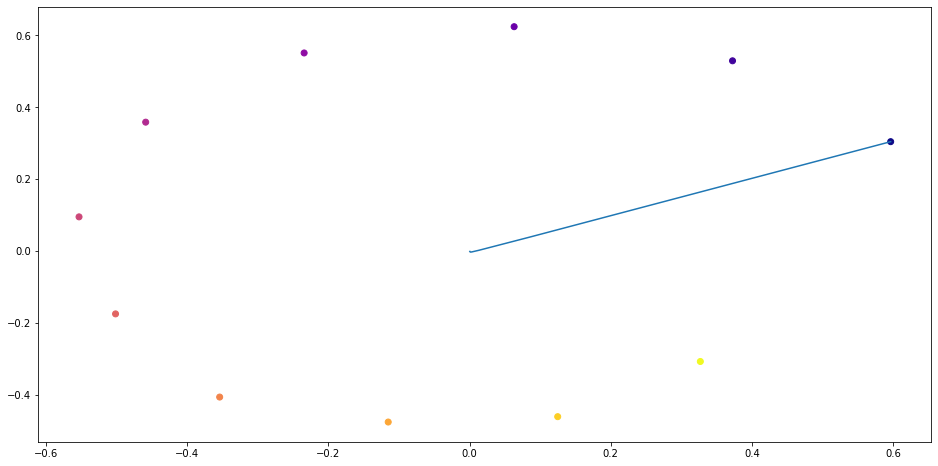

step: 2050, loss: 0.05732440948486328


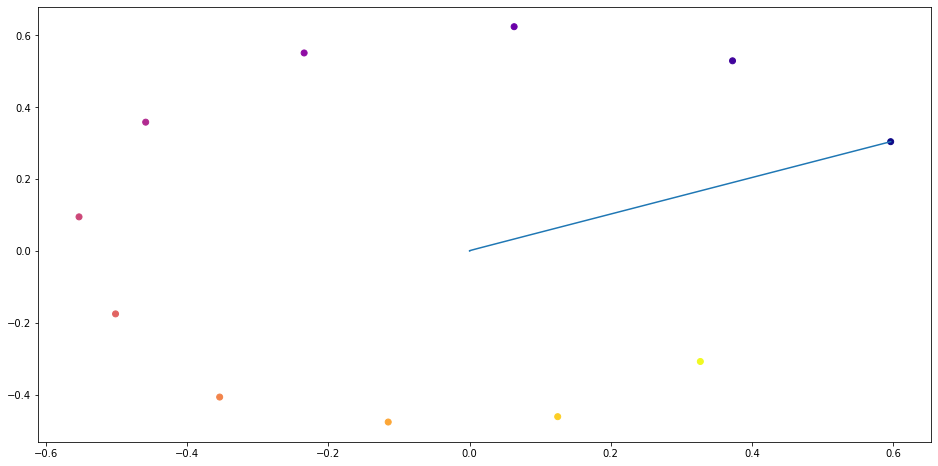

step: 2100, loss: 0.0693020224571228


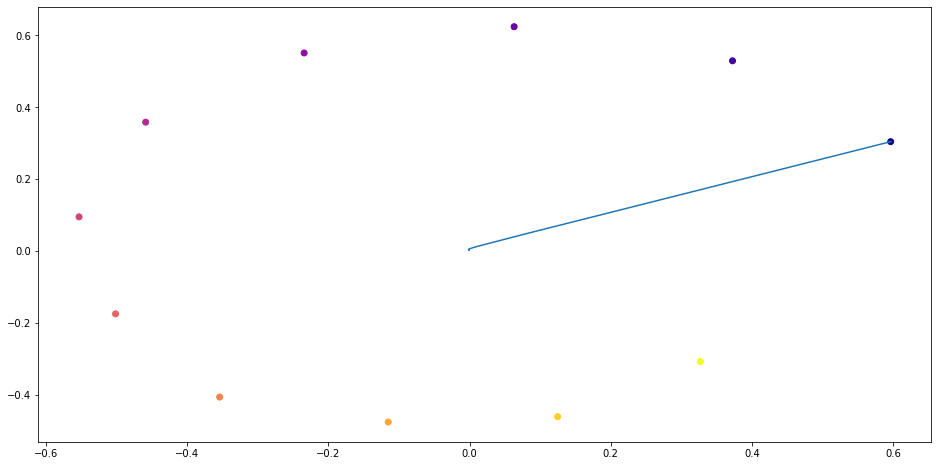

step: 2150, loss: 0.06585170328617096


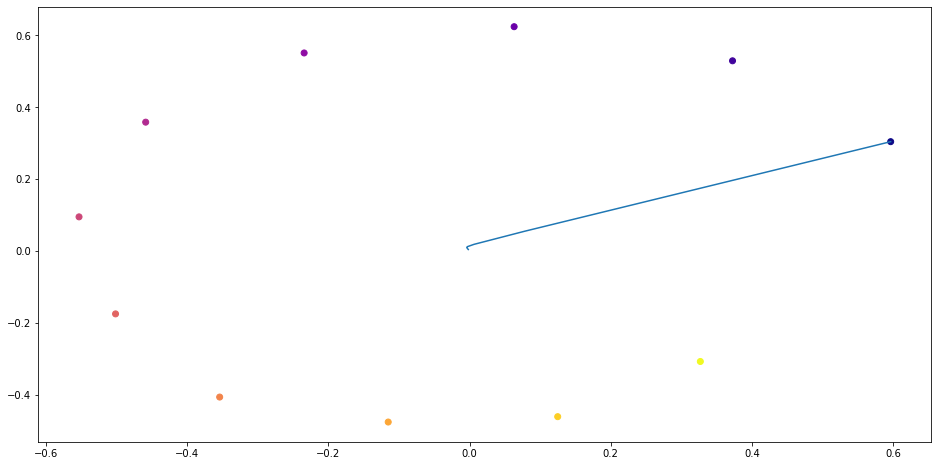

step: 2200, loss: 0.09989938139915466


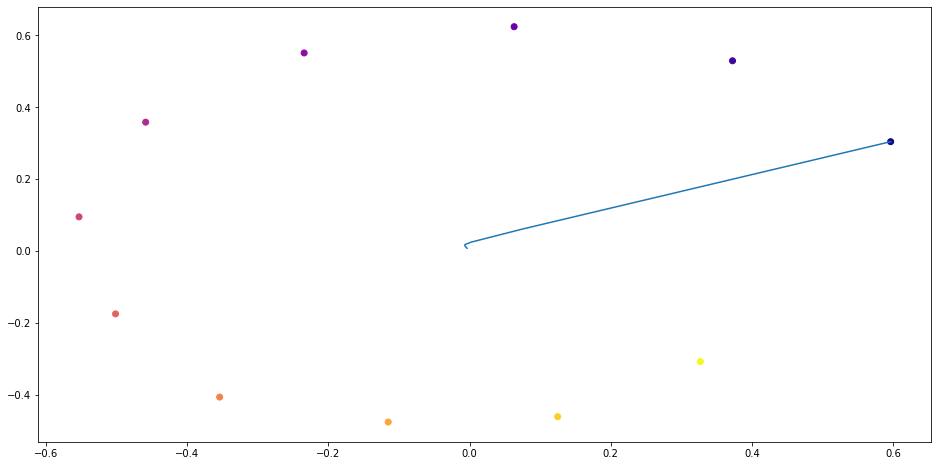

step: 2250, loss: 0.1291956603527069


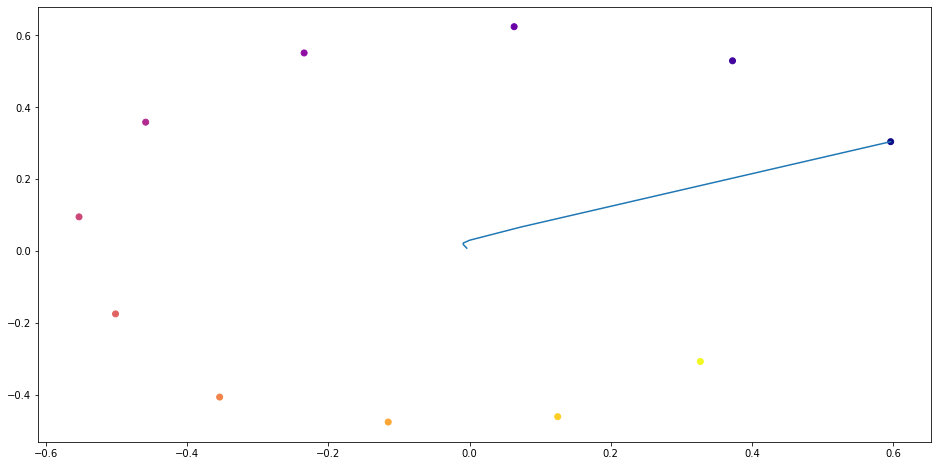

step: 2300, loss: 0.08985934406518936


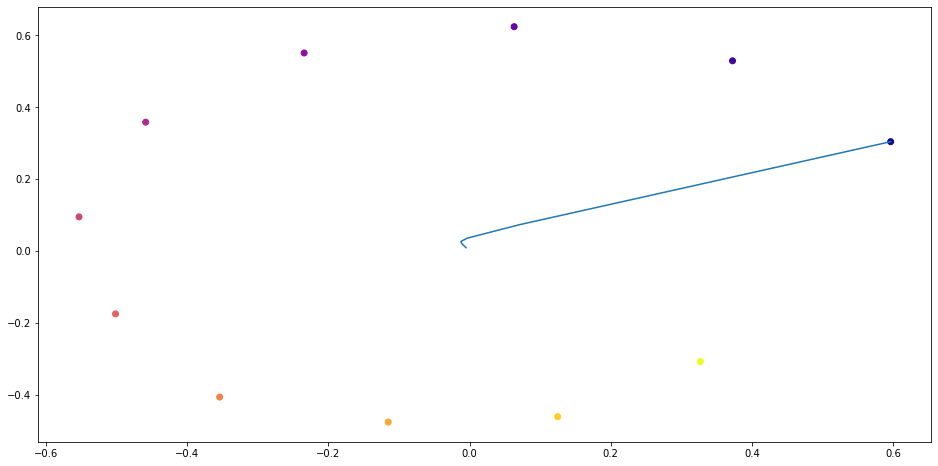

step: 2350, loss: 0.03987991437315941


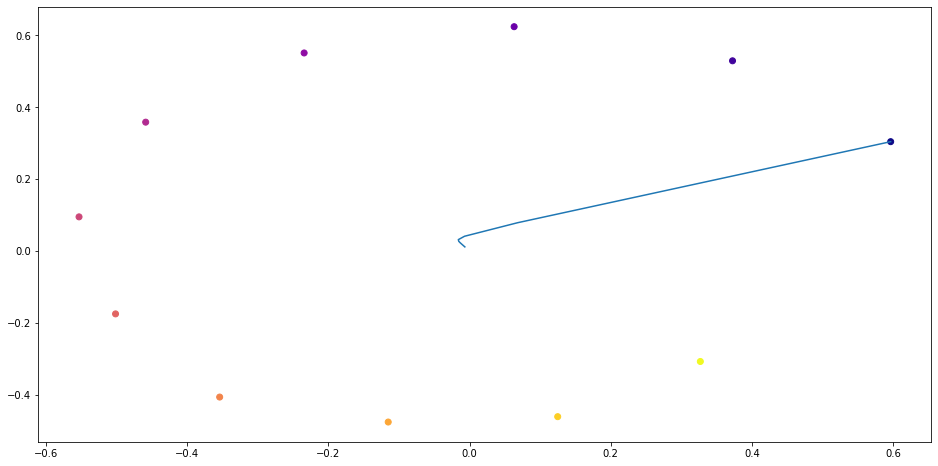

step: 2400, loss: 0.055688370019197464


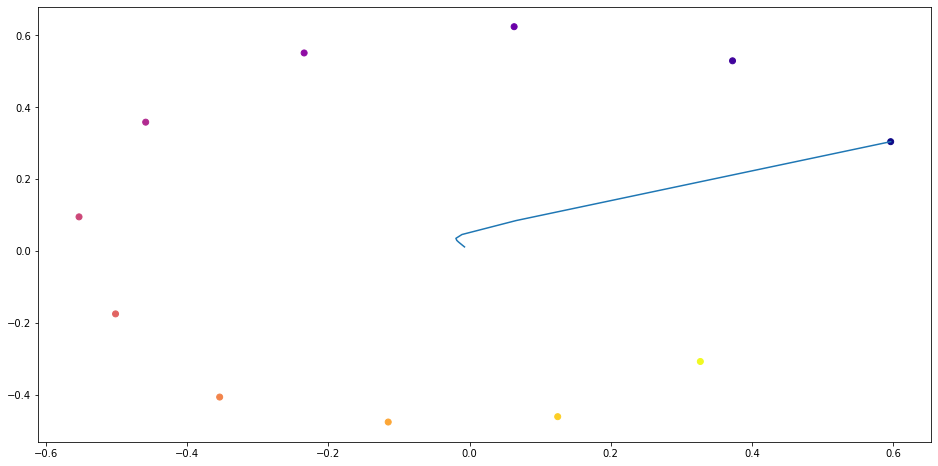

step: 2450, loss: 0.079282745718956


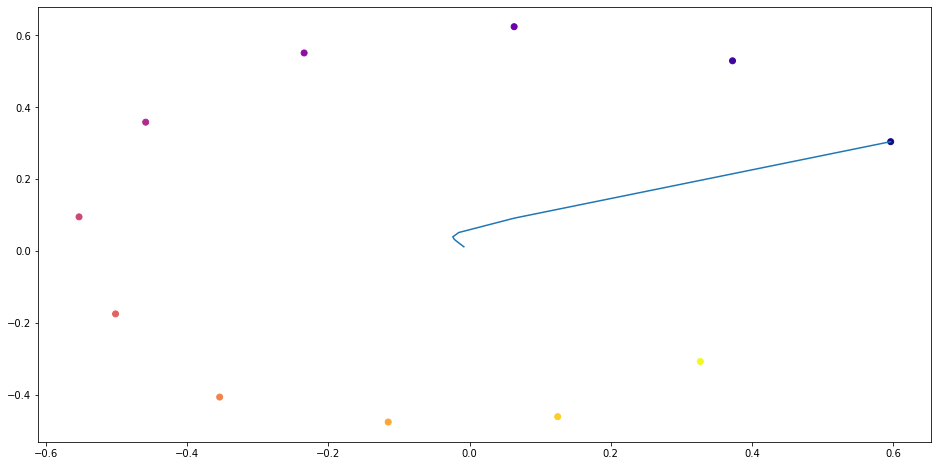

step: 2500, loss: 0.04970952495932579


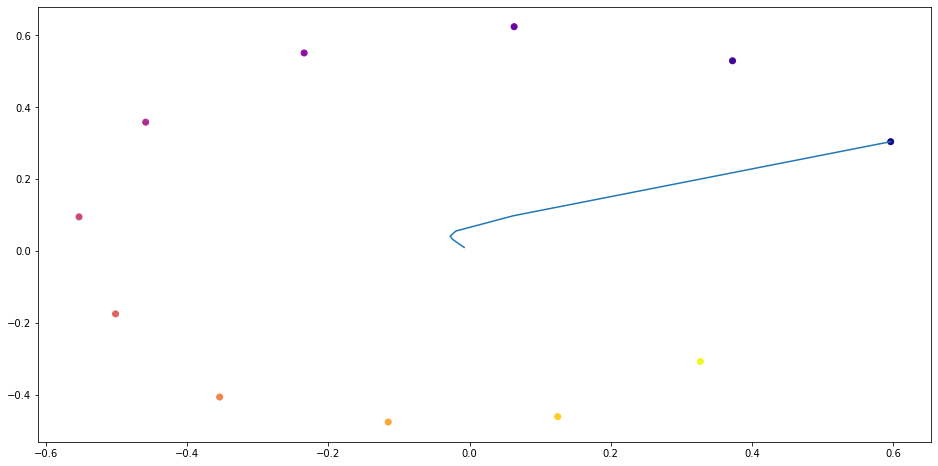

step: 2550, loss: 0.09144983440637589


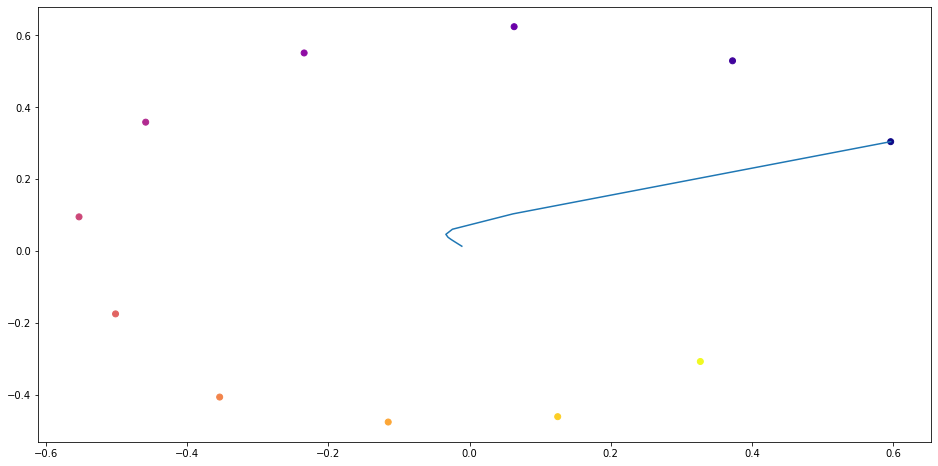

step: 2600, loss: 0.008698330260813236


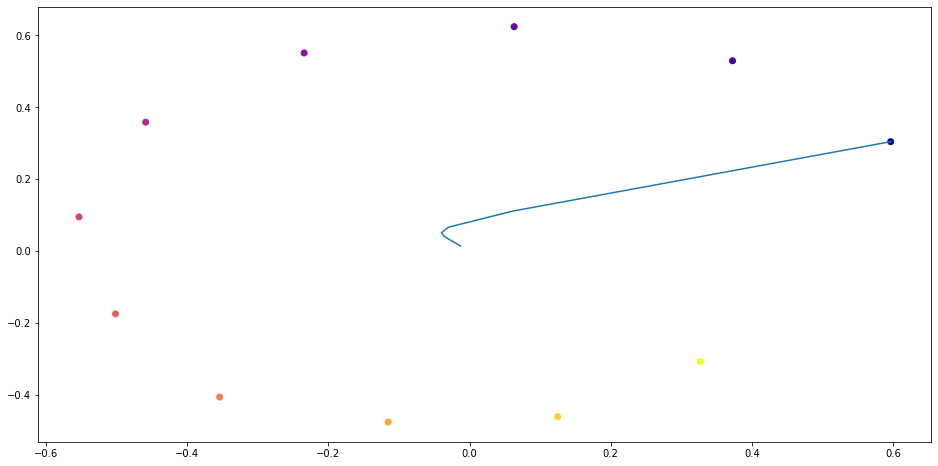

step: 2650, loss: 0.06811337918043137


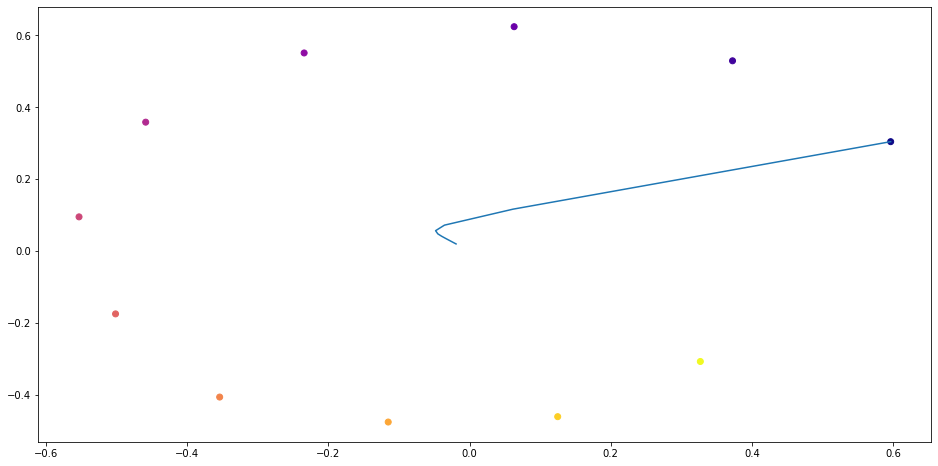

step: 2700, loss: 0.05592205002903938


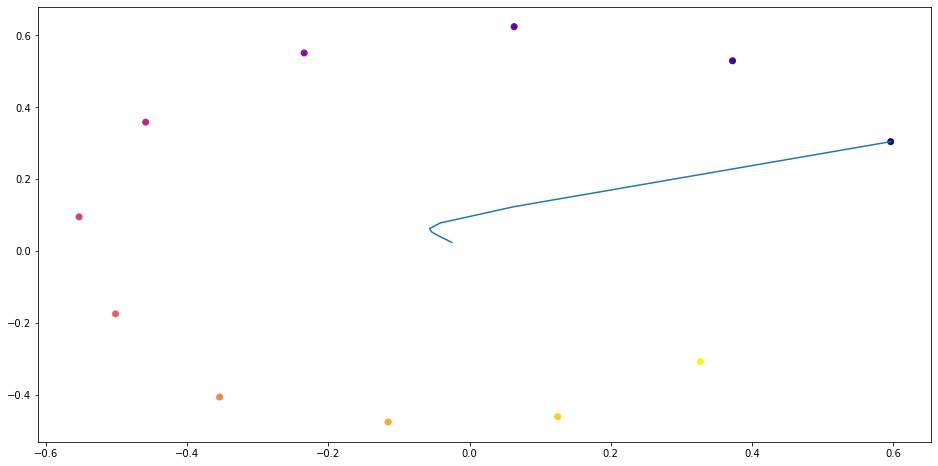

step: 2750, loss: 0.005487767979502678


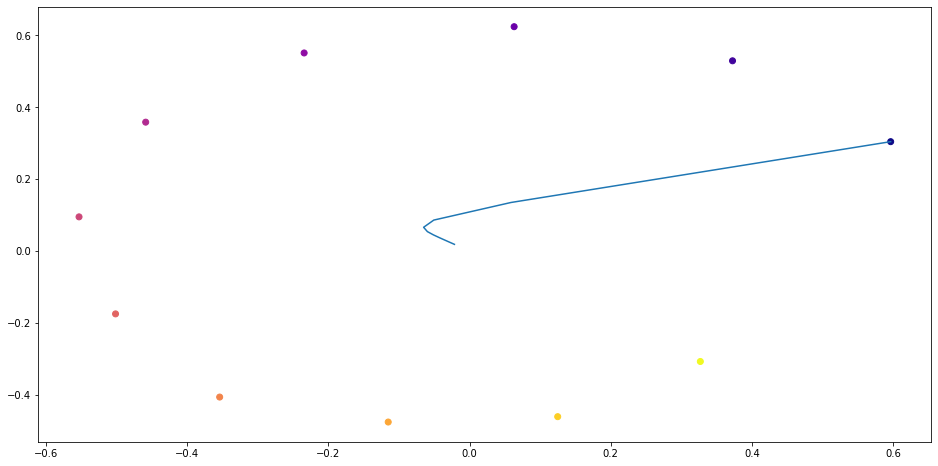

step: 2800, loss: 0.08001445978879929


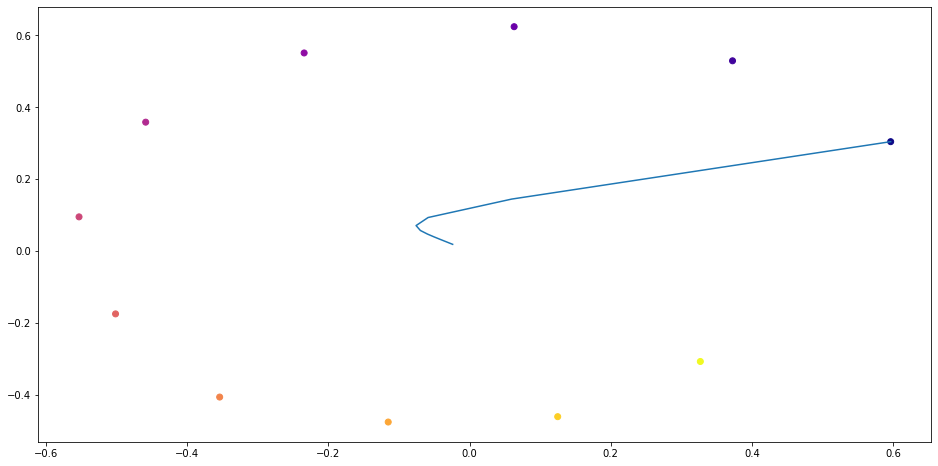

step: 2850, loss: 0.037941813468933105


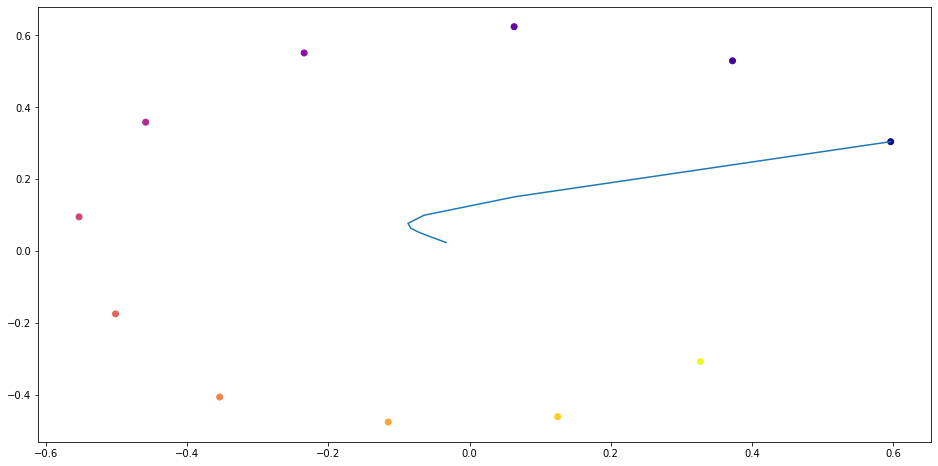

step: 2900, loss: 0.011190034449100494


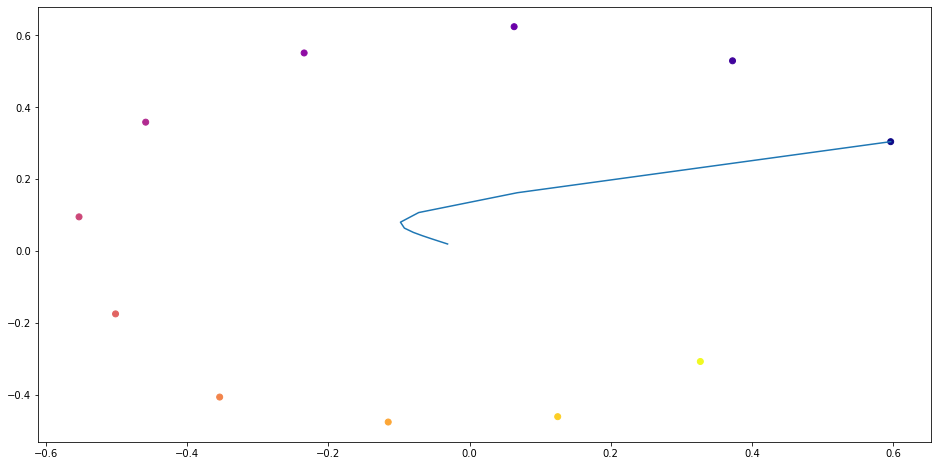

step: 2950, loss: 0.05954008549451828


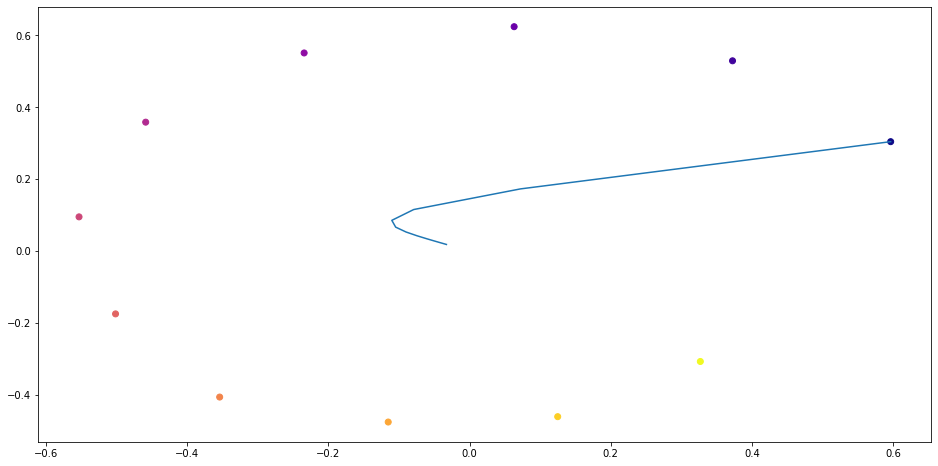

step: 3000, loss: 0.02300235442817211


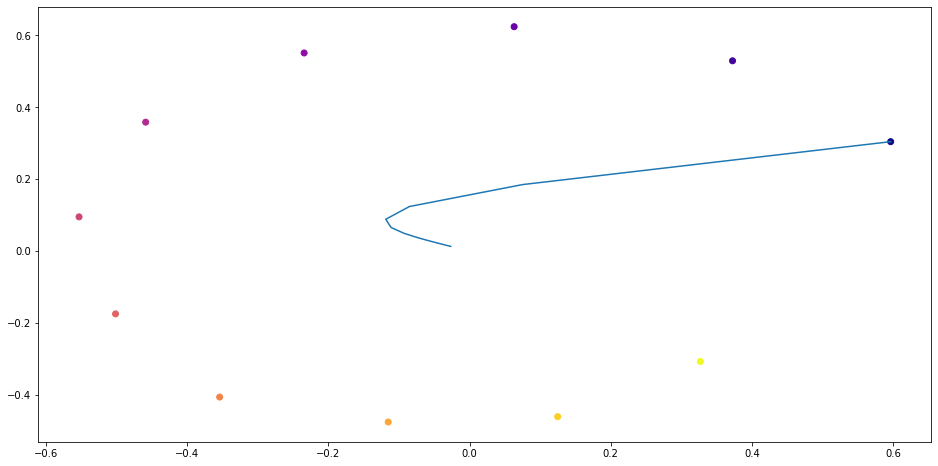

step: 3050, loss: 0.020299365743994713


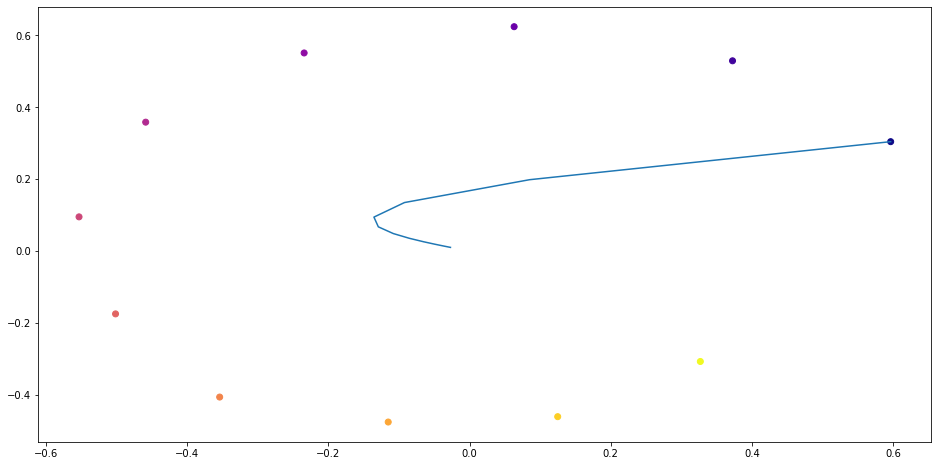

step: 3100, loss: 0.0680834949016571


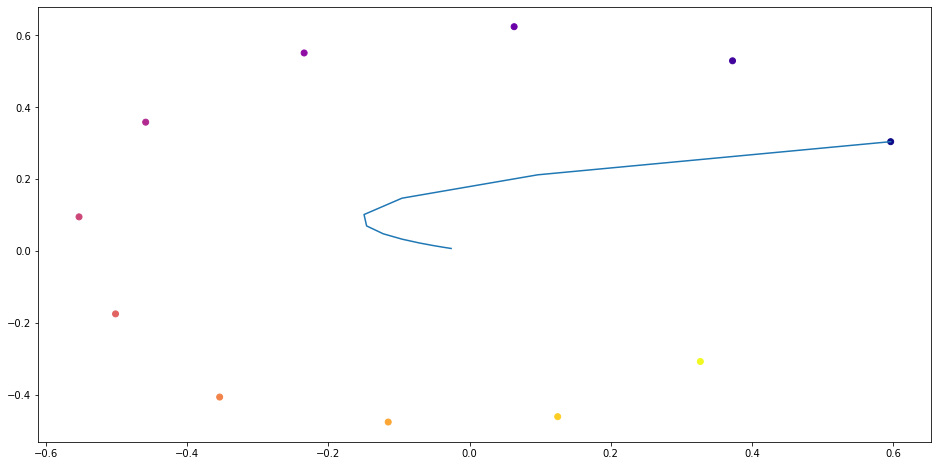

step: 3150, loss: 0.016982948407530785


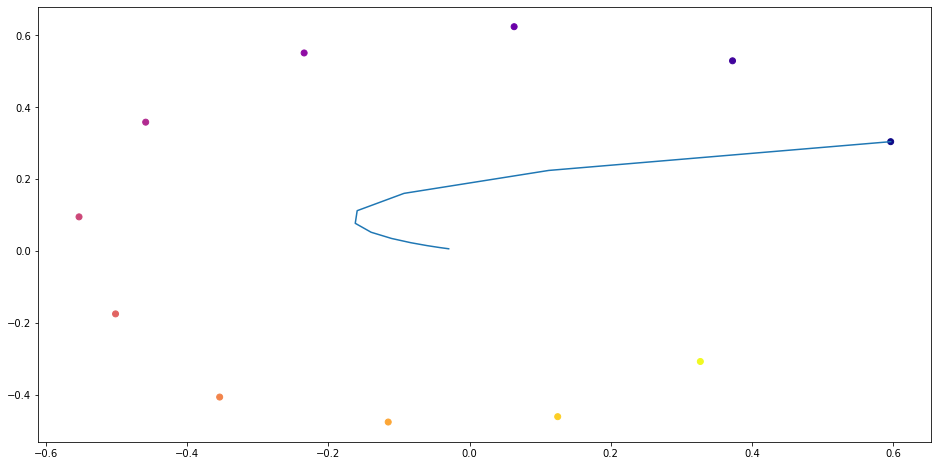

step: 3200, loss: 0.04033219441771507


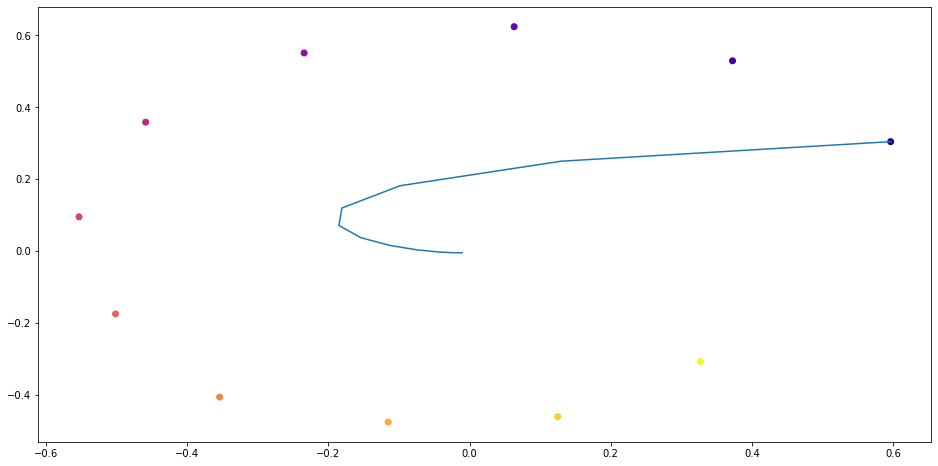

step: 3250, loss: 0.036802858114242554


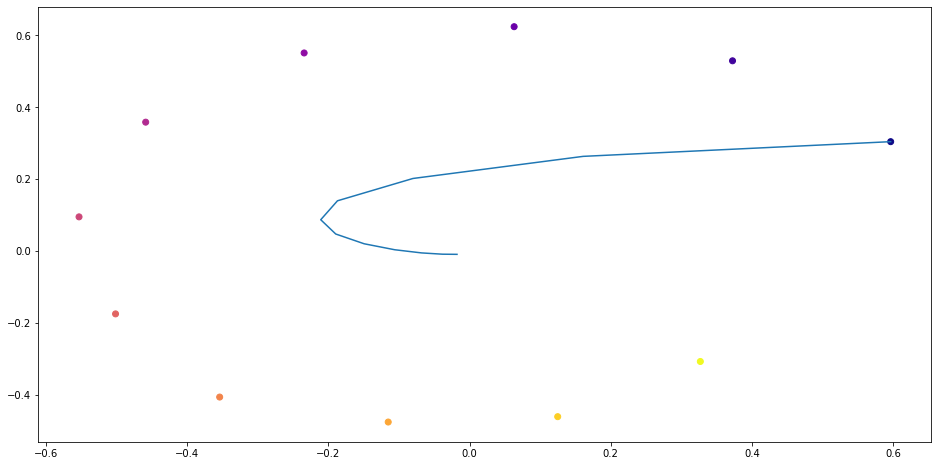

step: 3300, loss: 0.005313600413501263


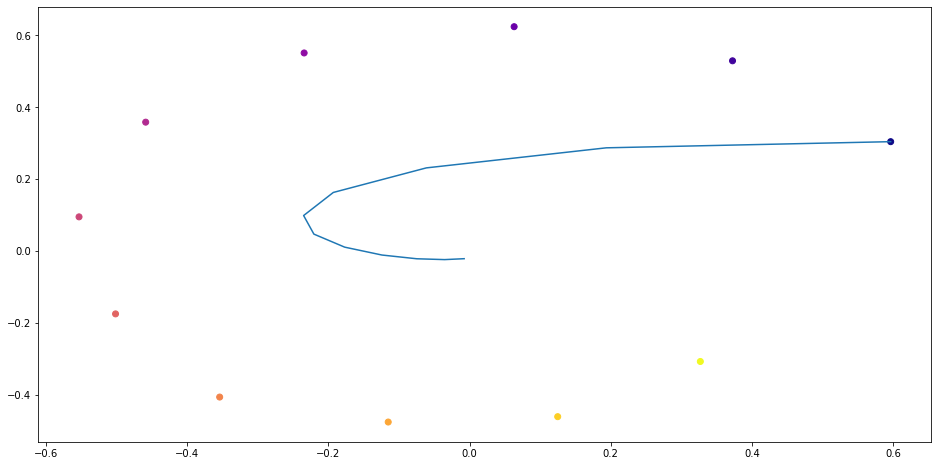

step: 3350, loss: 0.0070369006134569645


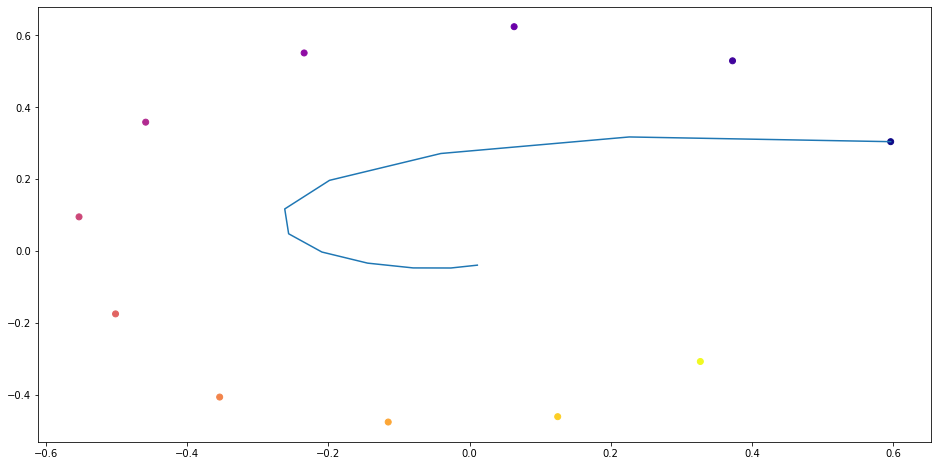

step: 3400, loss: 0.01059666182845831


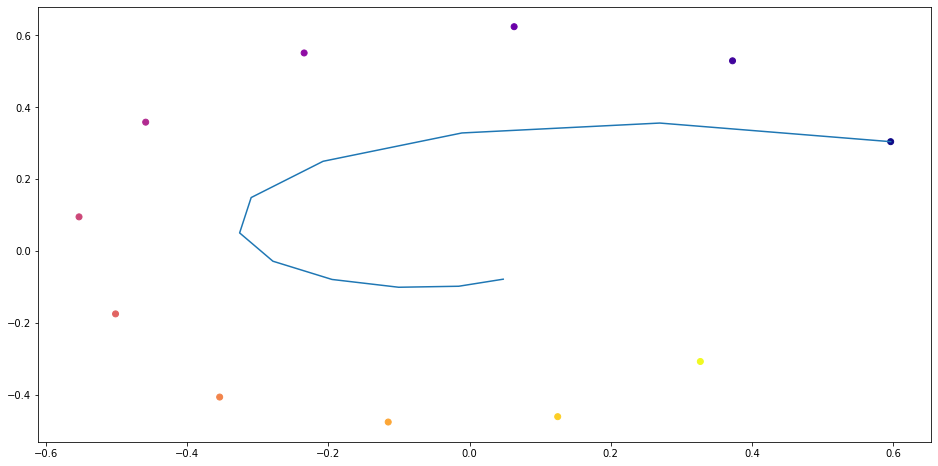

step: 3450, loss: 0.007070876657962799


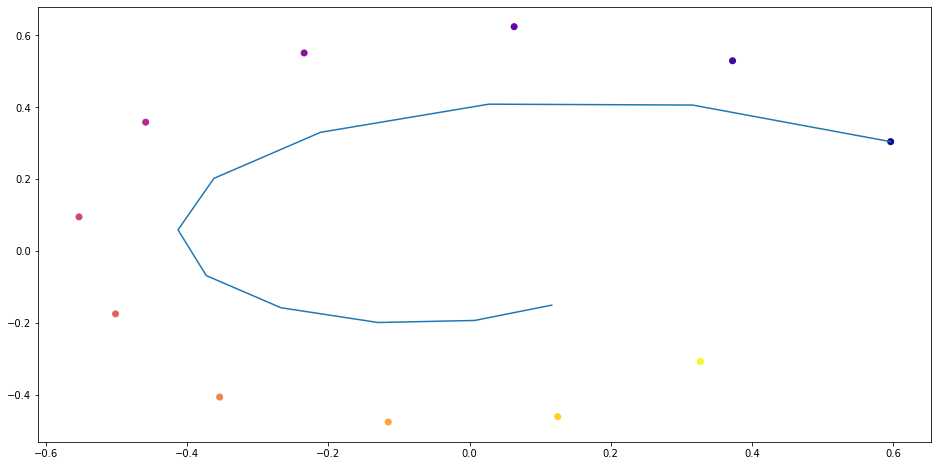

step: 3500, loss: 0.0008495982619933784


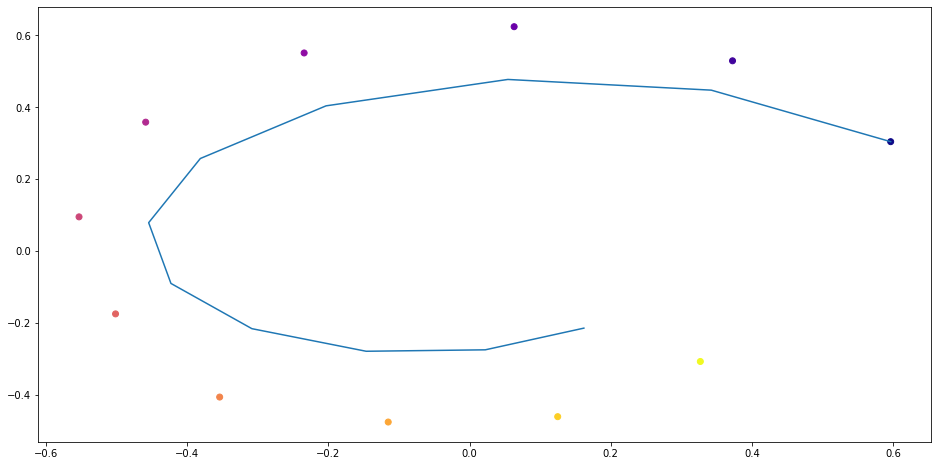

step: 3550, loss: 0.0009225179674103856


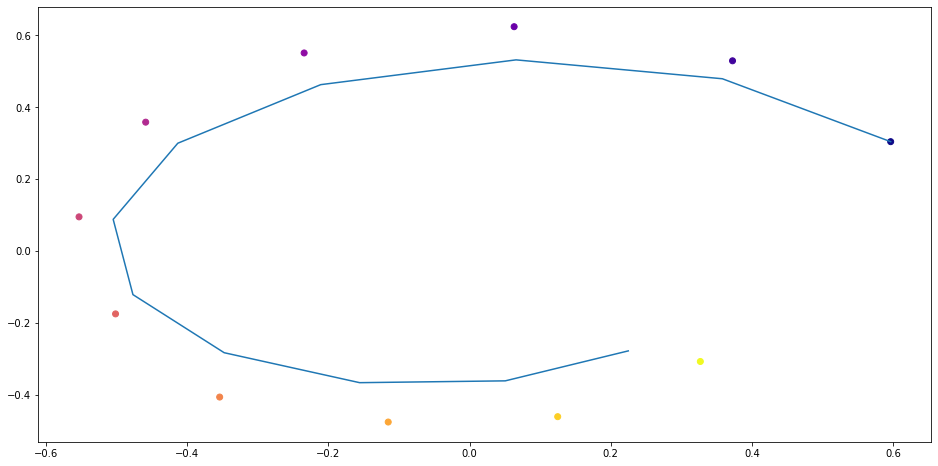

step: 3600, loss: 0.00027376748039387167


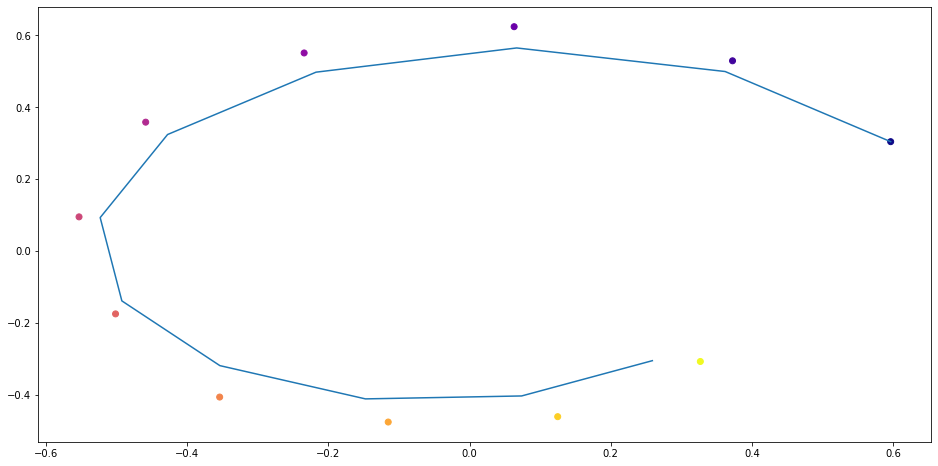

step: 3650, loss: 0.00012579566100612283


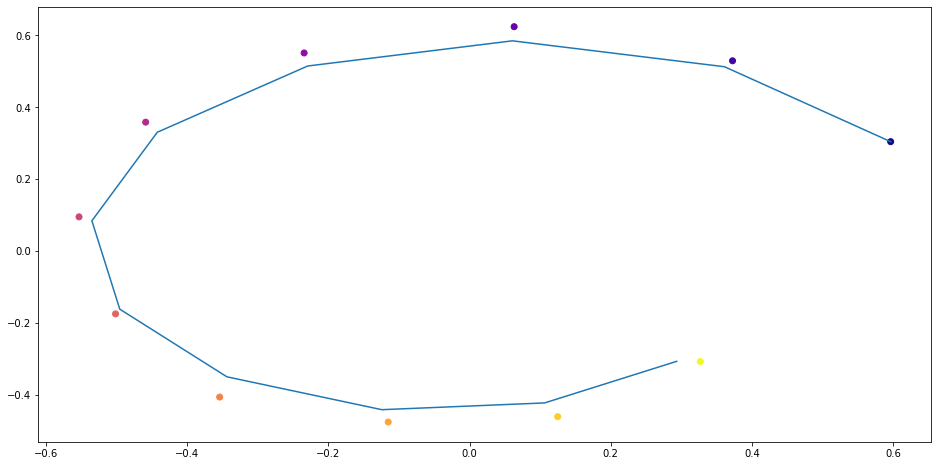

step: 3700, loss: 3.89473898394499e-05


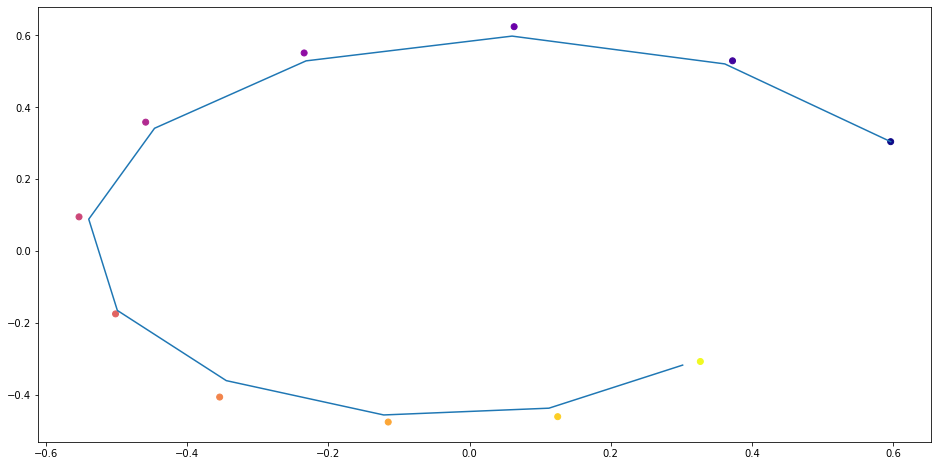

step: 3750, loss: 2.277889143442735e-05


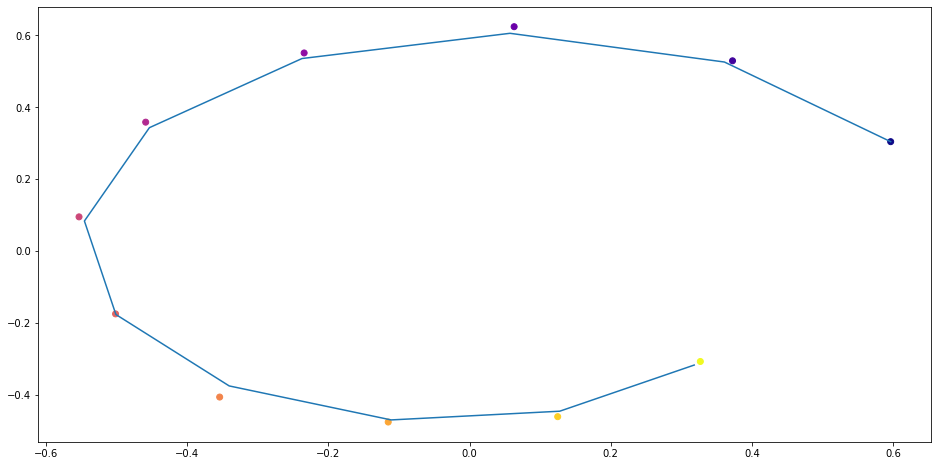

step: 3800, loss: 5.1727034588111565e-05


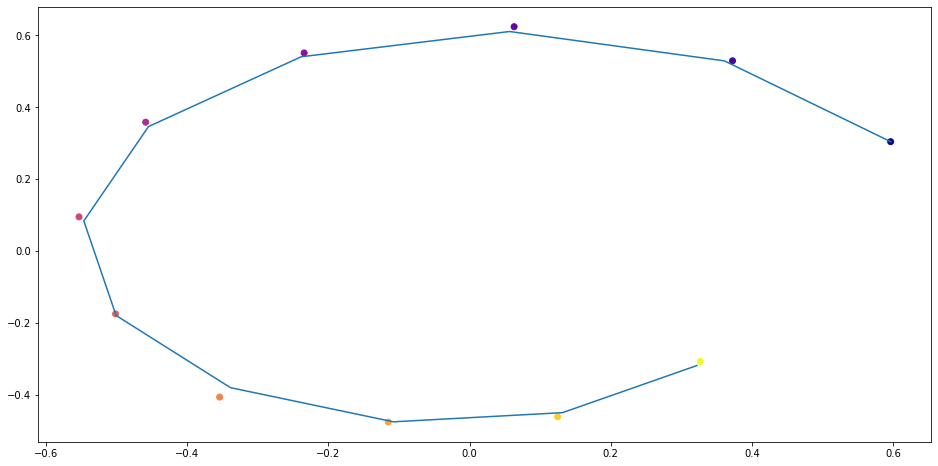

step: 3850, loss: 8.16082138044294e-06


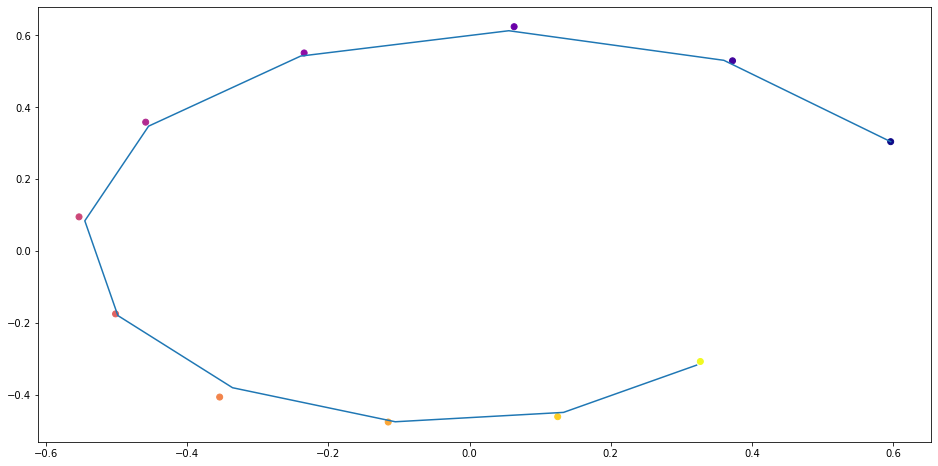

step: 3900, loss: 5.176011472940445e-05


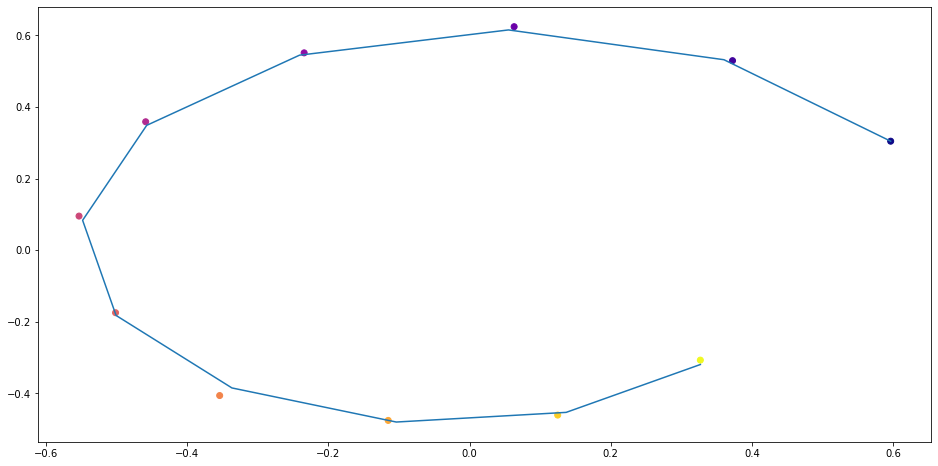

step: 3950, loss: 7.426297997881193e-06


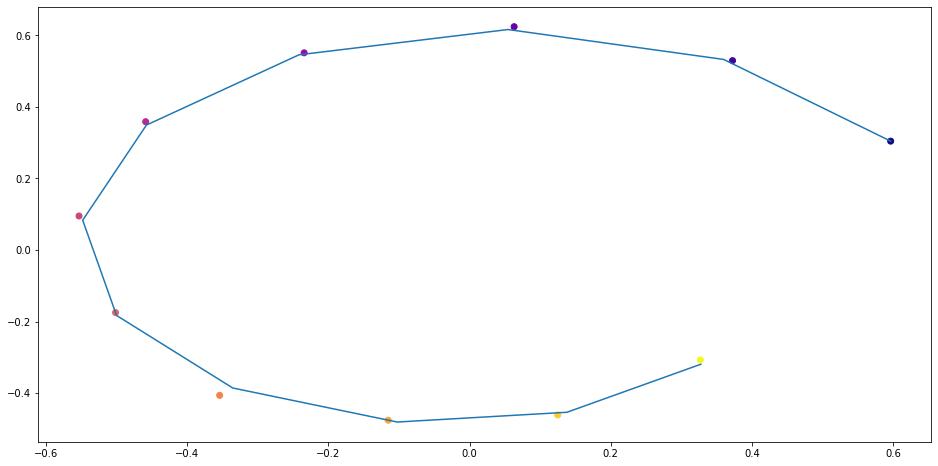

step: 4000, loss: 6.652708634646842e-06


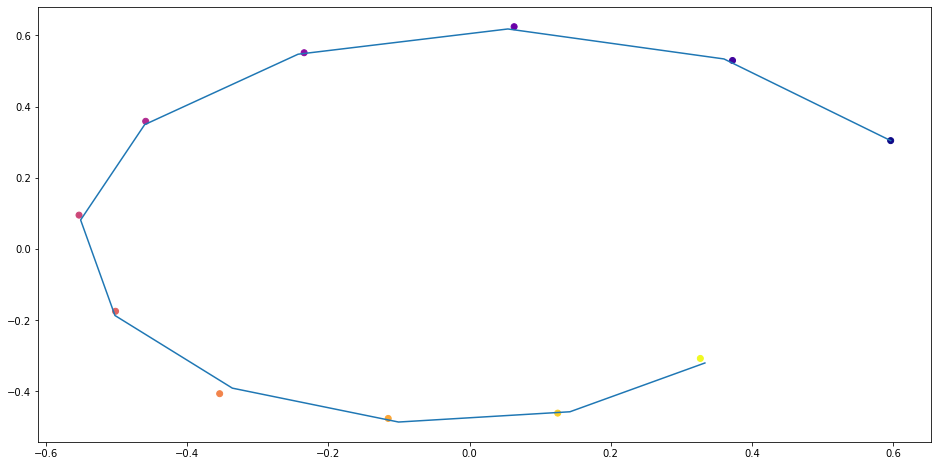

step: 4050, loss: 5.481326297740452e-05


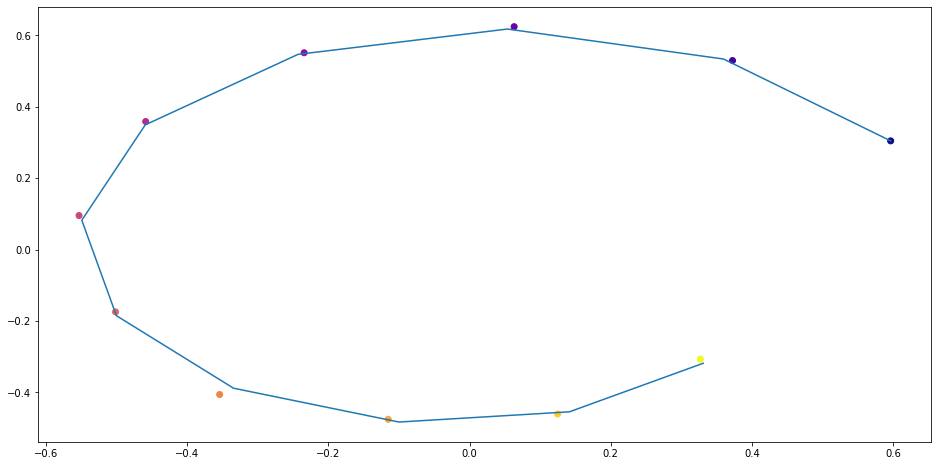

step: 4100, loss: 6.339877472782973e-06


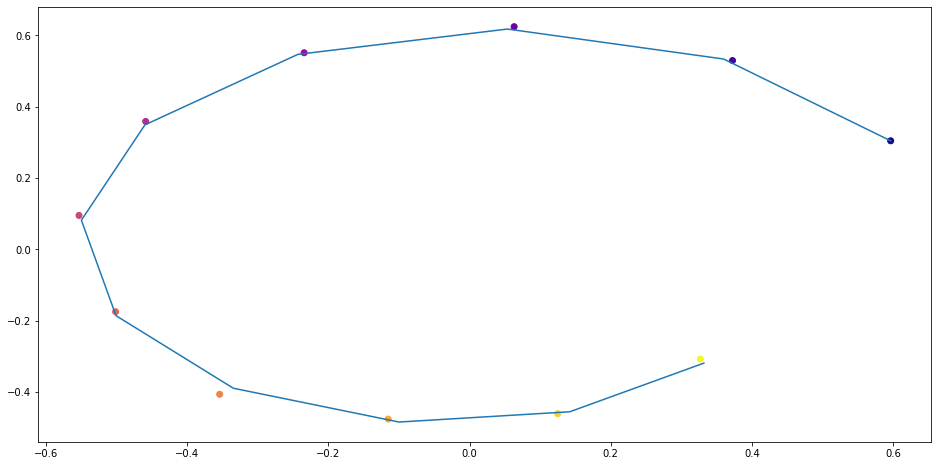

step: 4150, loss: 2.1567399016930722e-05


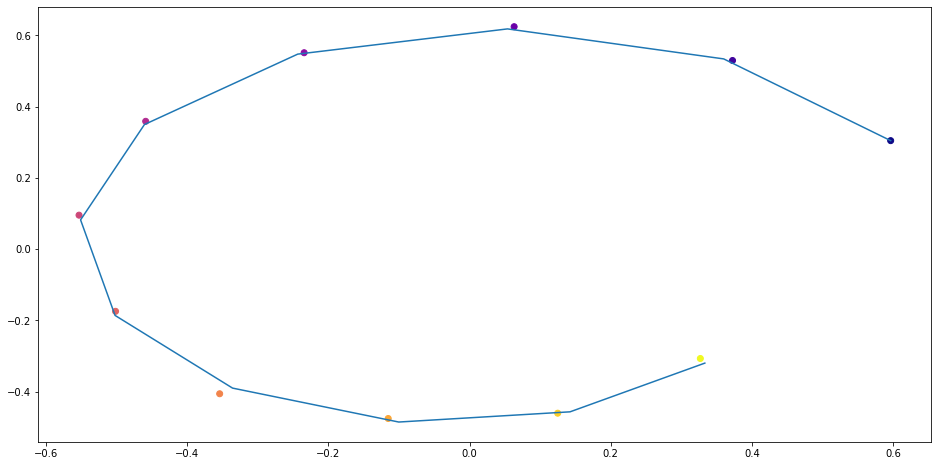

step: 4200, loss: 7.158134394558147e-06


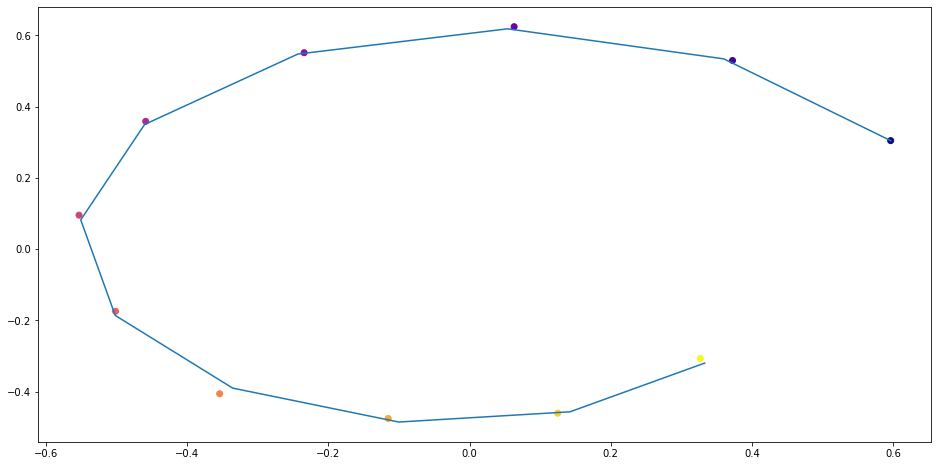

step: 4250, loss: 8.461985089525115e-06


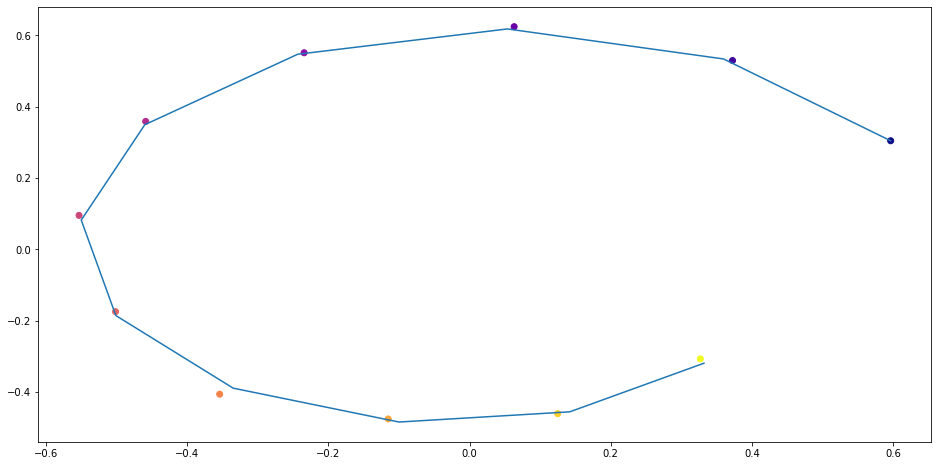

step: 4300, loss: 1.0732570444815792e-05


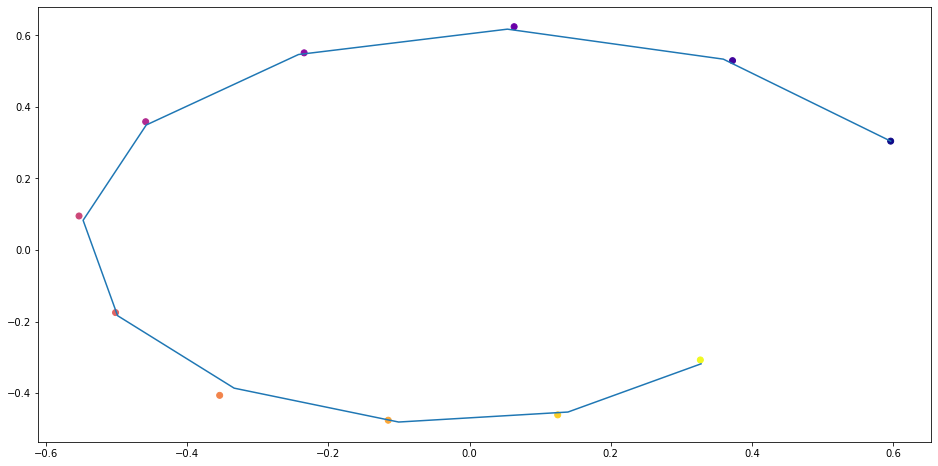

step: 4350, loss: 8.215145498979837e-06


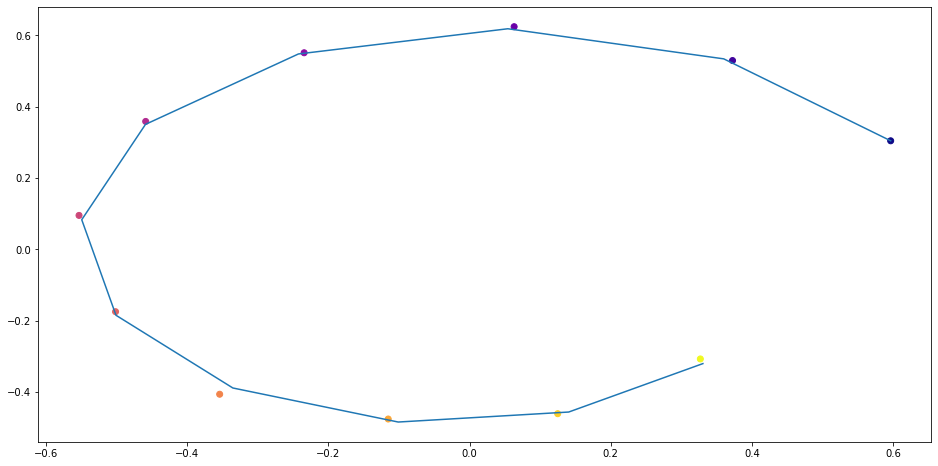

step: 4400, loss: 7.715785613982007e-06


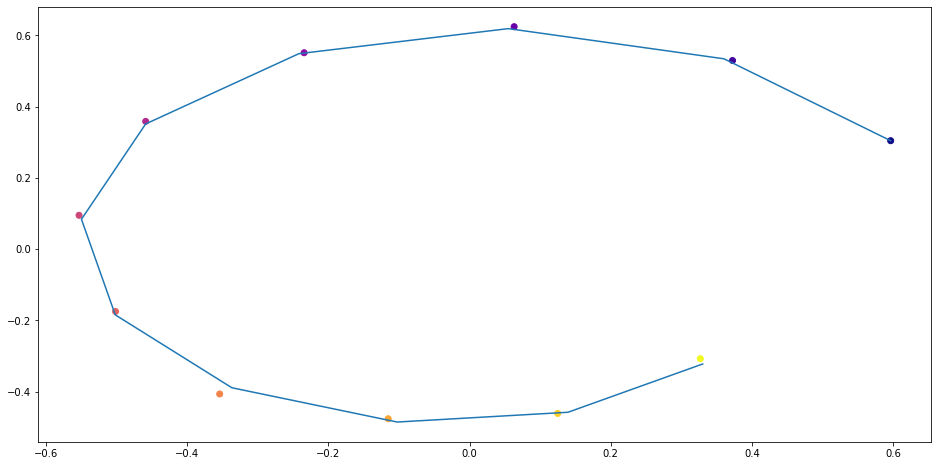

step: 4450, loss: 9.296416465076618e-06


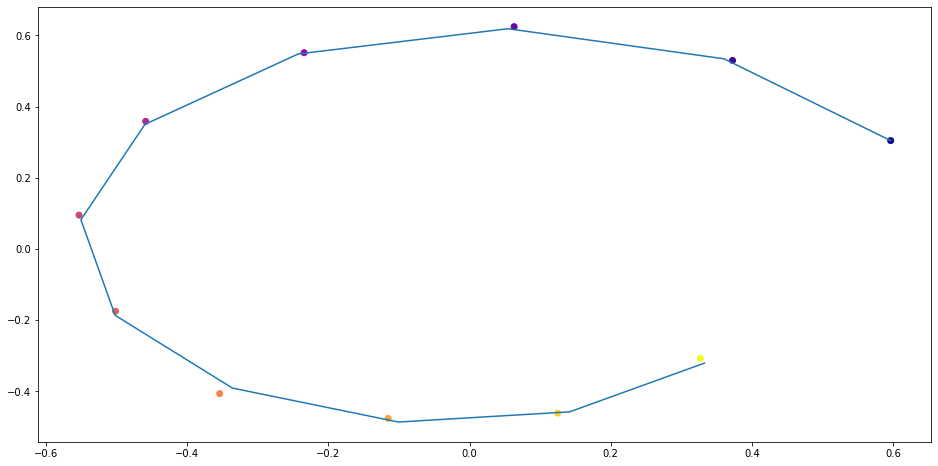

step: 4500, loss: 4.702369915321469e-05


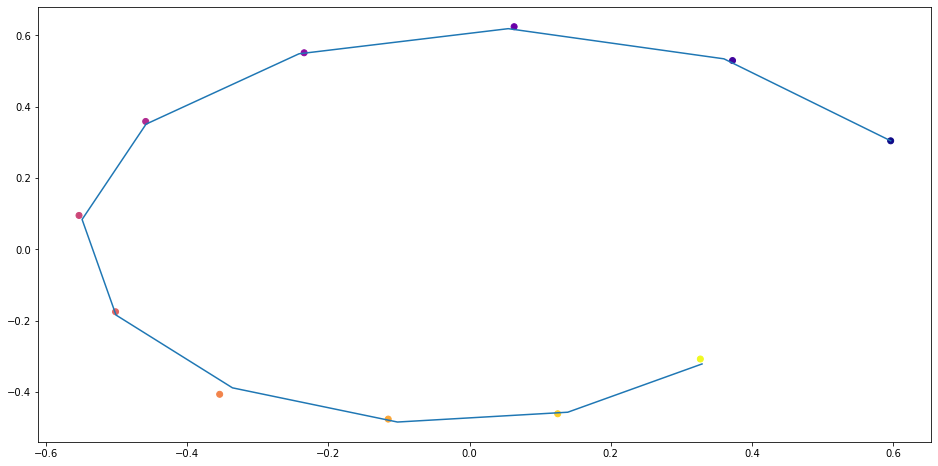

step: 4550, loss: 1.0044978807854932e-05


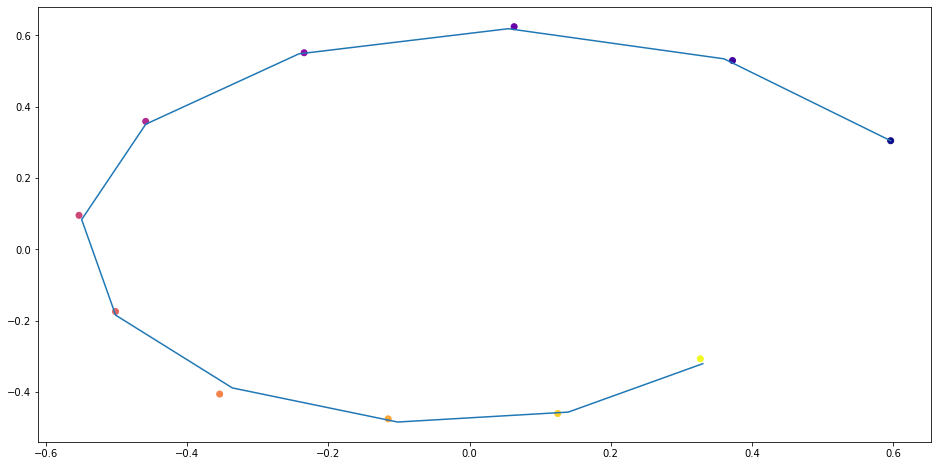

step: 4600, loss: 8.596549378125928e-06


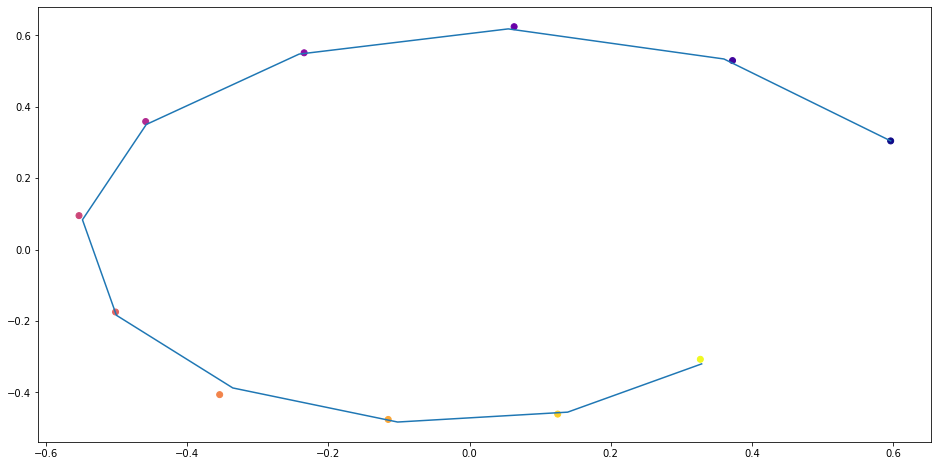

step: 4650, loss: 7.71856775827473e-06


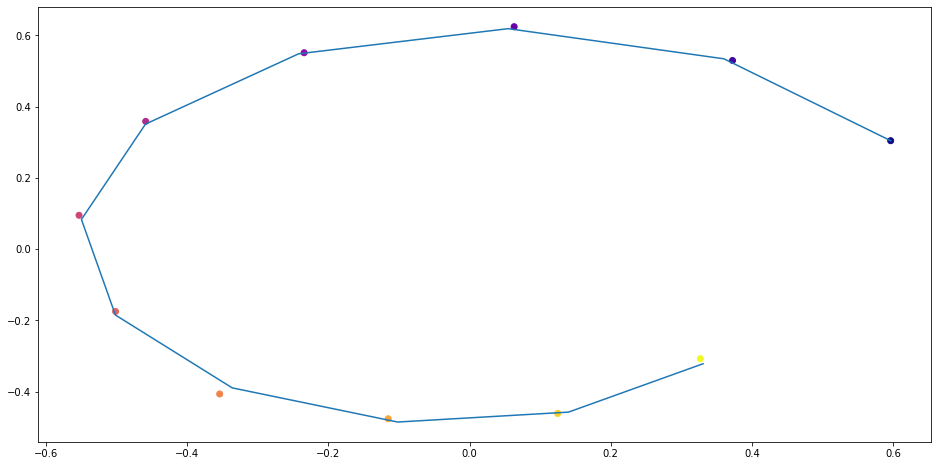

step: 4700, loss: 1.0409943570266478e-05


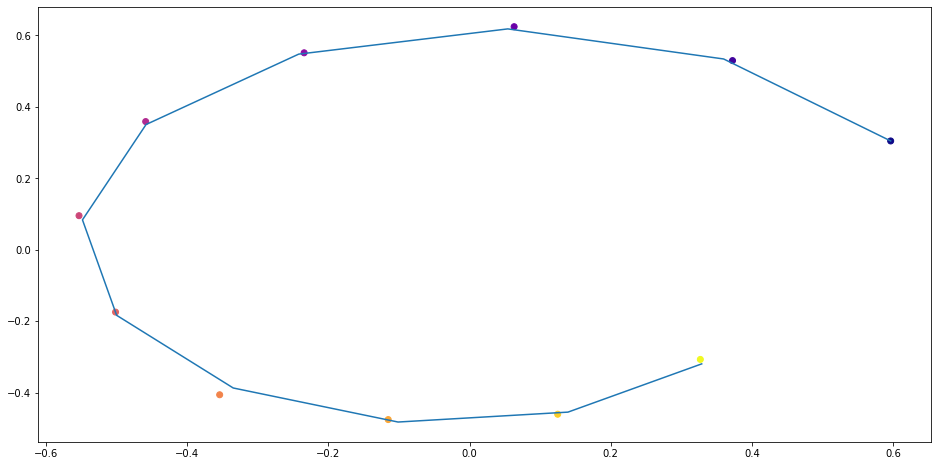

step: 4750, loss: 6.912937806191621e-06


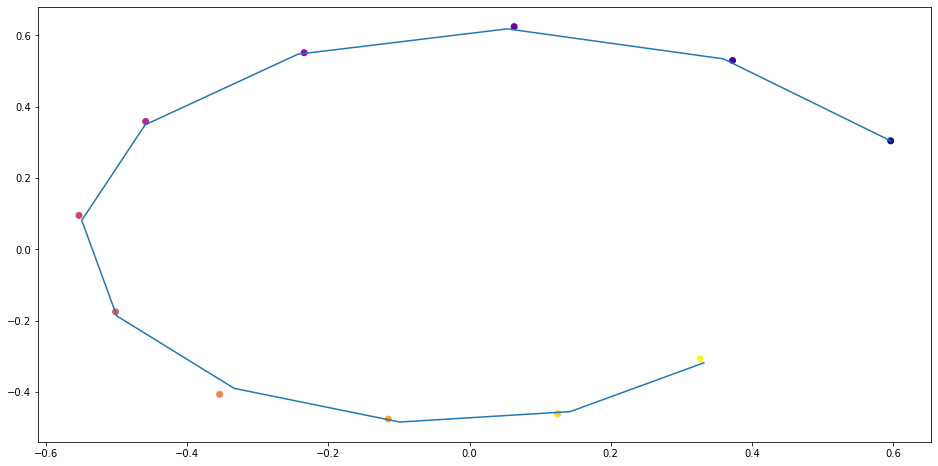

step: 4800, loss: 1.168455582956085e-05


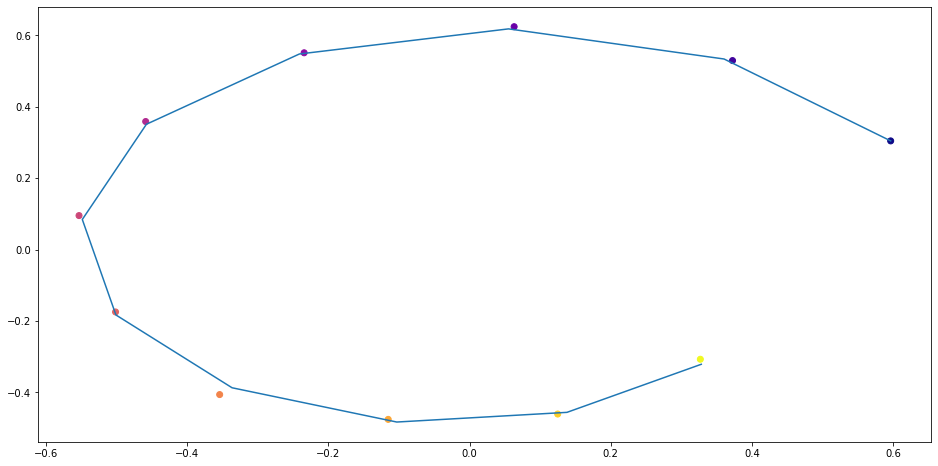

step: 4850, loss: 7.381192062894115e-06


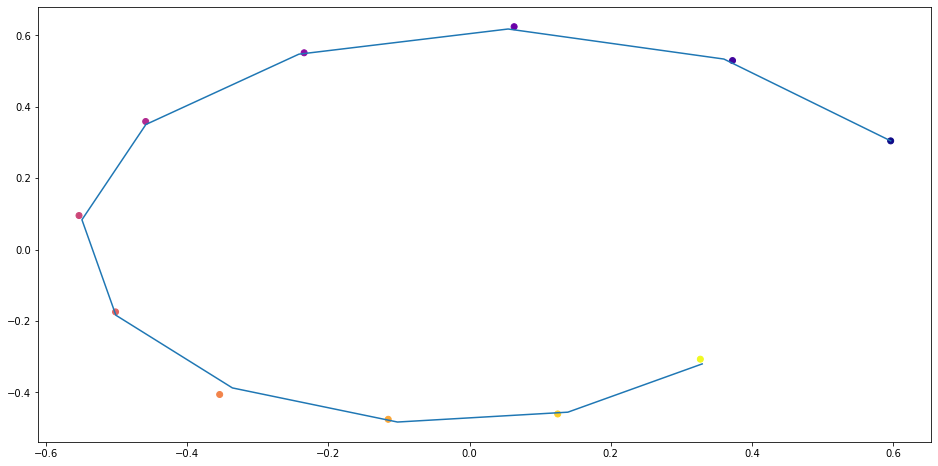

step: 4900, loss: 5.546704414882697e-05


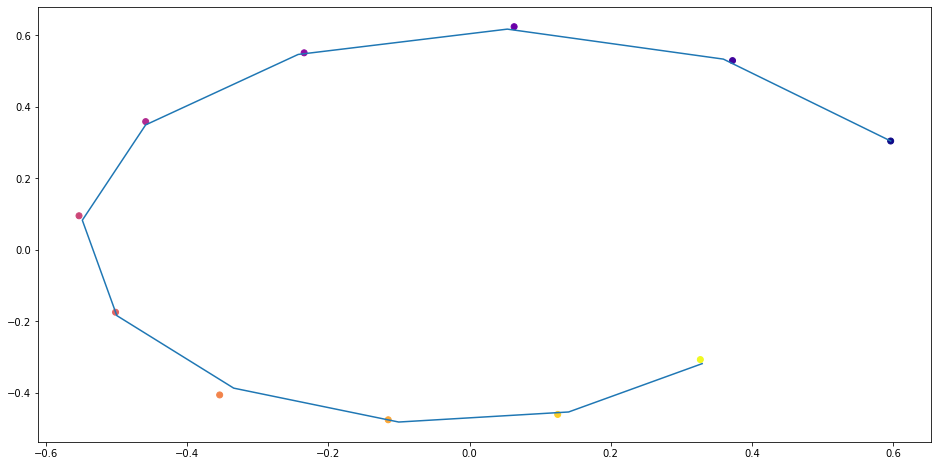

step: 4950, loss: 4.52767671959009e-05


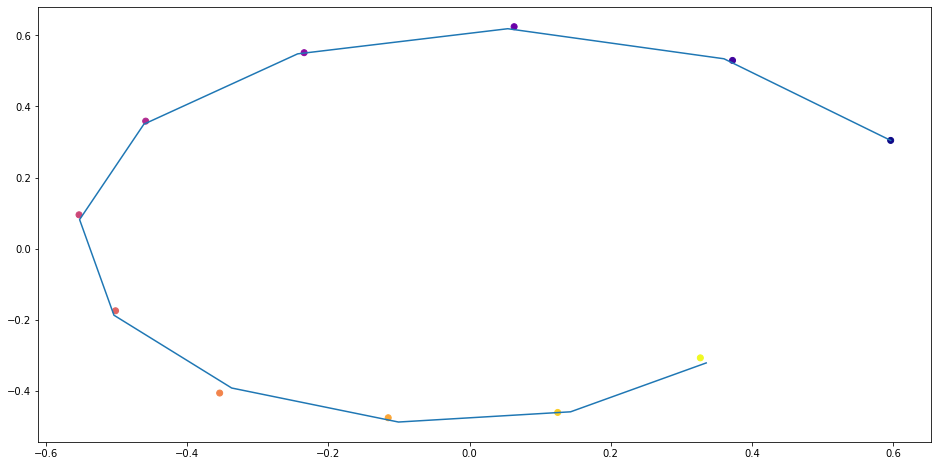

In [13]:
import numpy as np

import torch
from torch import nn
from torch import Tensor
from torch.autograd import Variable
from torch.nn  import functional as F

from NeuralODE import NeuralODE
from ODEfunc import ODEfunc
from plotter import plot_trajectories

use_cuda = torch.cuda.is_available()
torch.manual_seed(0)


class LinearODEF(ODEfunc):
    """
    Demo class with linear operation which have a 2x2 weight matrix operation
    """

    def __init__(self, W):
        super(LinearODEF, self).__init__()
        # time independent ODE
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        # x.shape (bs, x_dim)
        # t.shape (bs, 1)
        return self.lin(x)


def generate_trajectory(ode, initial_value, n_points=200, t_max=6.29 * 5):
    """
    Generate the trajectory using the Neural ODE function
    :param ode: Neural ODE
    :param initial_value: z0
    :param n_points: total number of samples
    :param t_max: number of samples
    :return:
    """
    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])  # (n_points, 1)

    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])  # (n_points, 1)

    # (n_points, 1, 1), first dimension is time stamp
    times = torch.from_numpy(times_np[:, :, None]).to(initial_value)

    # (n_points, 1, z_dim) Solved ODE
    observations = ode.forward(initial_value, times, return_whole_sequence=True).detach()

    # add noise to the observation
    observations = observations + torch.randn_like(observations) * 0.01

    return observations, index_np, times_np, times


def create_batch(obs, idx_np, time_np, times, t_max=5):
    """
    TODO: Why only a small batch but not all data?
    Create batches of output from the training ODE
    :param indices: indices of time stamps
    :param times: time stamps
    :param t_max: last time stamp
    :return: observation tensor and corresponding time stamp
    """
    # define length of the random timespan
    min_delta_time = 1.0
    max_delta_time = 4.
    # maximum number of points
    max_points_num = 64

    t0 = np.random.uniform(0, t_max - max_delta_time)
    t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

    idx = sorted(np.random.permutation(idx_np[(time_np > t0) & (time_np < t1)])[:max_points_num])

    obs_ = obs[idx]
    ts_ = times[idx]
    return obs_, ts_


if __name__ == '__main__':
    # set hyper parameter
    n_step = 5000 # gradient descent step
    plot_freq = 50

    # noinspection PyArgumentList
    SpiralFunctionExample = LinearODEF(Tensor([[-0.1, -1.], [1., -0.1]]))
    # RandomLinearODEF = LinearODEF(torch.randn(2, 2))
    # Random seed is not a good way to start, can't converge easily
    RandomLinearODEF = LinearODEF(Tensor([[-1, 1], [-1, 1]]))

    ode_true = NeuralODE(SpiralFunctionExample)
    ode_trained = NeuralODE(RandomLinearODEF)

    # Create data and initial value
    # noinspection PyArgumentList
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    # generate the labels from true trajectory
    t_max = 5
    n_points = 11
    # (time index, batch size, dimension of output)
    obs, index_np, time_np, times = generate_trajectory(ode_true, z0, n_points=n_points, t_max=t_max)

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)

    # Training cycle:
    for i in range(n_step):
        # Forward Pass for training Model. Get trajectory of random timespan
        obs_batch, ts_batch = create_batch(obs, index_np, time_np, times, t_max=t_max)
        z_batch = ode_trained(obs_batch[0], ts_batch, return_whole_sequence=True)

        # compare label with model output
        loss = F.mse_loss(z_batch, obs_batch.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # Plot the trajectory
        # plot_trajectories(obs=[obs], times=[time_np], trajs=[obs_]

        if i % plot_freq == 0:
            print("step: {}, loss: {}".format(i, loss))
            z_p = ode_trained(obs[0], times, return_whole_sequence=True)
            plot_trajectories(obs=[obs], times=[times], trajs=[z_p])

    test = 0